In [54]:
from mobster_mv2 import mobster_MV
import numpy as np
import pandas as pd
import pyro.distributions as dist

import torch
import seaborn as sns

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics.cluster import normalized_mutual_info_score
import warnings

import sys
# Set the parent directory
parent_dir = ".."
# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)
from BoundedPareto import BoundedPareto
from plot_functions import *
from create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
def plot_paretos_1(mb):
    alpha_pareto = mb.params["alpha_pareto"]
    fig, ax = plt.subplots(nrows=alpha_pareto.shape[0], ncols=alpha_pareto.shape[1])
    fig.tight_layout()
    x = np.arange(0,0.5,0.001)
    k = 0
    for d in range(alpha_pareto.shape[1]):
        pdf = pareto.pdf(x, alpha_pareto[k,d], scale=0.01)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d} - alpha {round(float(alpha_pareto[k,d]), ndigits=2)}")

def plot_betas_1(mb):
    phi_beta = mb.params["phi_beta"]
    kappa_beta = mb.params["k_beta"]

    fig, ax = plt.subplots(nrows=phi_beta.shape[0], ncols=phi_beta.shape[1])
    fig.tight_layout()
    x = np.arange(0,1,0.001)
    k = 0
    for d in range(phi_beta.shape[1]):
        a = phi_beta[k,d]*kappa_beta[k,d]
        b = (1-phi_beta[k,d])*kappa_beta[k,d]
        pdf = beta.pdf(x, a, b)
        ax[d].plot(x, pdf, 'r-', lw=1)
        ax[d].set_title(f"Dimension {d}")

In [56]:
def log_sum_exp(args):
    c = torch.amax(args, dim=0)
    return c + torch.log(torch.sum(torch.exp(args - c), axis=0)) # sum over the rows (different clusters), so obtain a single likelihood for each data

def beta_lk(data, DP, a_beta, b_beta, weights):
    # return torch.log(weights) + dist.Beta(a_beta, b_beta).log_prob(probs_beta) + dist.Binomial(total_count=DP, probs = probs_beta).log_prob(data) # simply does log(weights) + log(density)
    return torch.log(weights) + dist.BetaBinomial(a_beta, b_beta, total_count=DP).log_prob(data) # simply does log(weights) + log(density)


def pareto_lk(data, DP, alpha, weights):
    # return torch.log(weights) + BoundedPareto(0.01, alpha, 0.55).log_prob(probs_pareto) + dist.Binomial(total_count=DP, probs = probs_pareto).log_prob(data) # simply does log(weights) + log(density)
    probs = BoundedPareto(0.01, alpha, 0.55).sample()
    return torch.log(weights) + dist.Binomial(total_count=DP, probs = probs).log_prob(data) # simply does log(weights) + log(density)


def compute_likelihood(mb, beta = True, dim = 0, k = 0):
    NV = mb.NV[:, dim]
    DP = mb.DP[:, dim]
    weights = mb.params["weights"][k]
    if beta == True:
        phi_beta = mb.params["phi_beta"][k, dim]
        k_beta = mb.params["k_beta"][k, dim]
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        return log_sum_exp(beta_lk(NV, DP, a_beta, b_beta, weights)).sum()
    else:
        alpha = mb.params["alpha_pareto"][k, dim]
        probs_pareto = mb.params["probs_pareto"][k, dim]
        return log_sum_exp(pareto_lk(NV, DP, alpha, weights)).sum()

### One beta component

Trying to understand if the problem is the $\delta$ or the parameter convergence:
- if one dim of the cluster is assigned to the pareto but the likelihood of beta is higher, then the $\delta$ is wrong
- if one dim of the cluster is assigned to the pareto and the likelihood of pareto is higher, then the parameter convergence is wrong

In [57]:
N1 = 1000
seed = 123
# Component 1
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.1
k_beta_y= 250
n1=150
NV, DP = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n1, N=N1, seed=seed)
# 
print(DP.shape)

torch.Size([1000, 2])


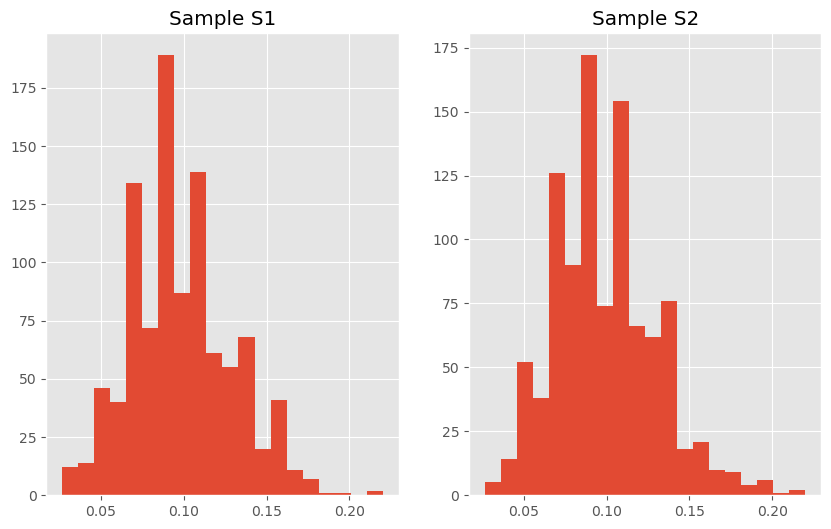

In [58]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [59]:
labels = np.zeros(N1)

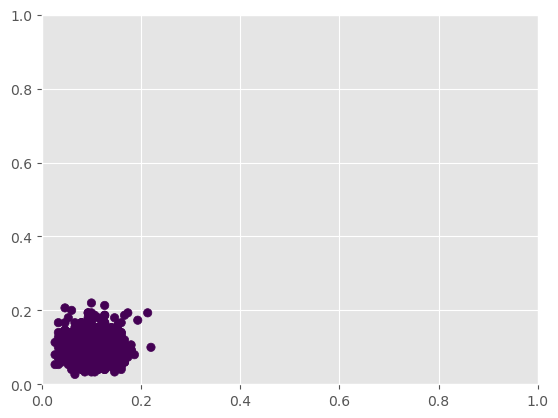

In [60]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0986, 0.0994]])
Iteration 0: Loss = 13054.9462890625
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0201, 2.0201]], grad_fn=<AddBackward0>)
alpha_param tensor([[1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0978, 0.0986]], grad_fn=<AddBackward0>)
k_beta_param tensor([[100.4912, 100.5185]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0978, 0.0986]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3637, 0.6363],
         [0.3367, 0.6633]]], grad_fn=<DivBackward0>)


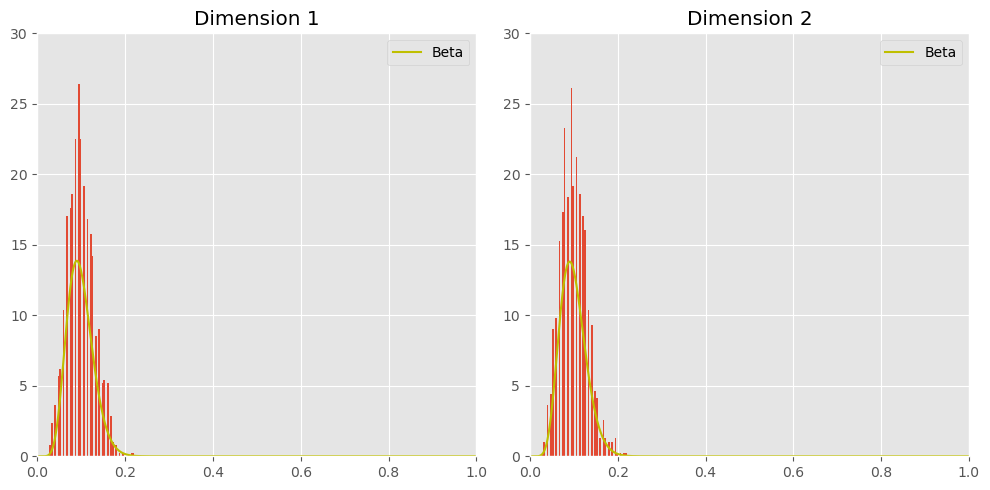

Iteration 200: Loss = -1486.34912109375
Iteration 400: Loss = -1544.2308349609375
phi_beta [[0.0962231  0.09652443]]
delta [[[0.9189377  0.08106235]
  [0.91496694 0.0850331 ]]]


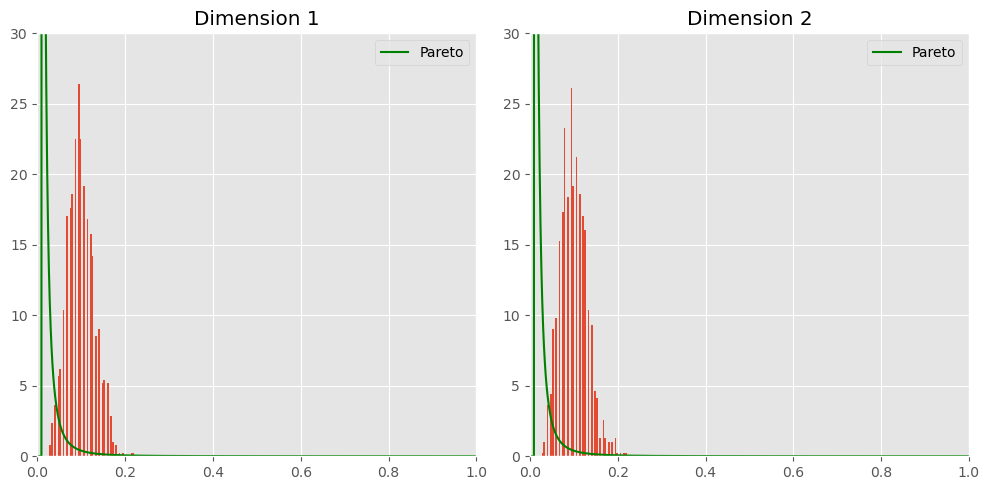

Iteration 600: Loss = -1560.696044921875
Iteration 800: Loss = -1567.47705078125
phi_beta [[0.09623408 0.09651845]]
delta [[[0.9735203  0.02647976]
  [0.97259855 0.02740148]]]


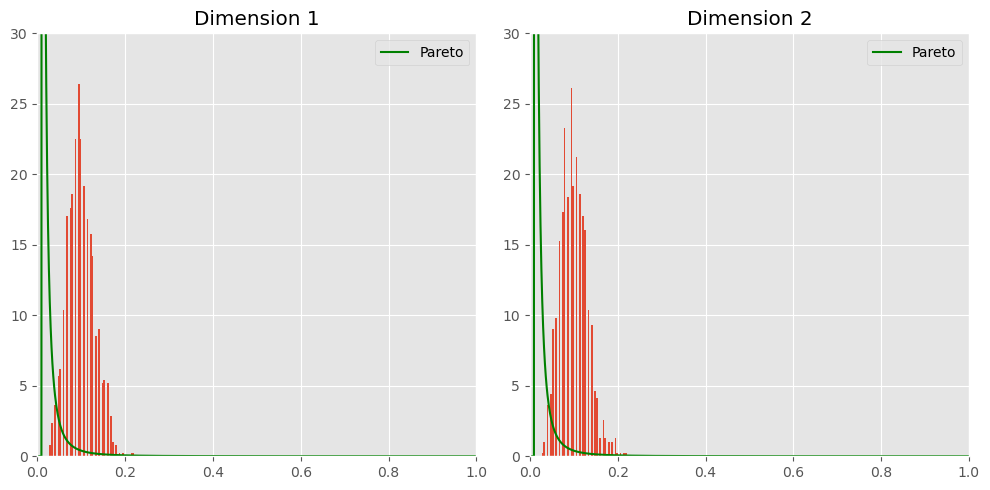

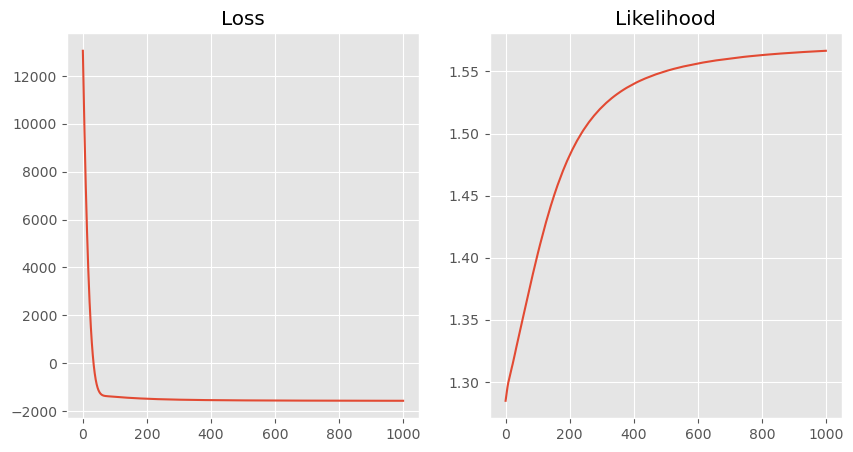

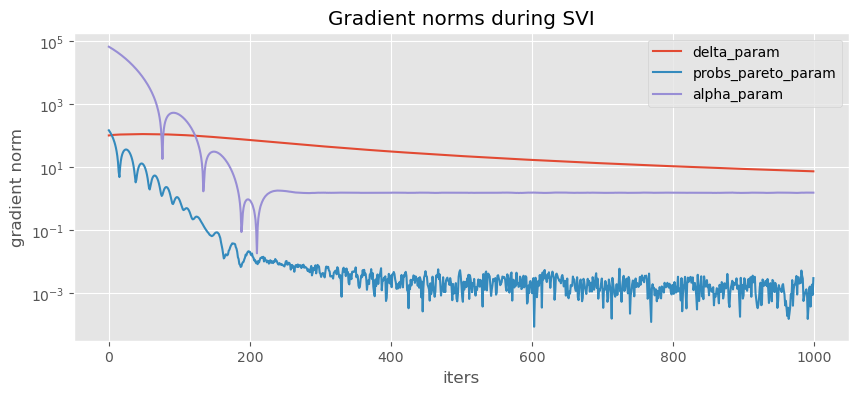

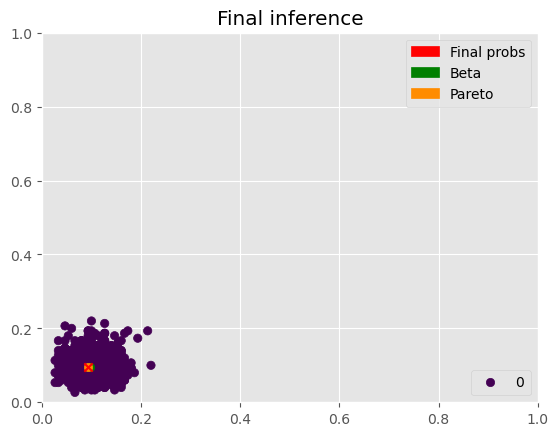

In [61]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 1000, lr = 0.005)

In [62]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(4.0101)
tensor(0.2144)
tensor(4.0129)
tensor(3.0306)


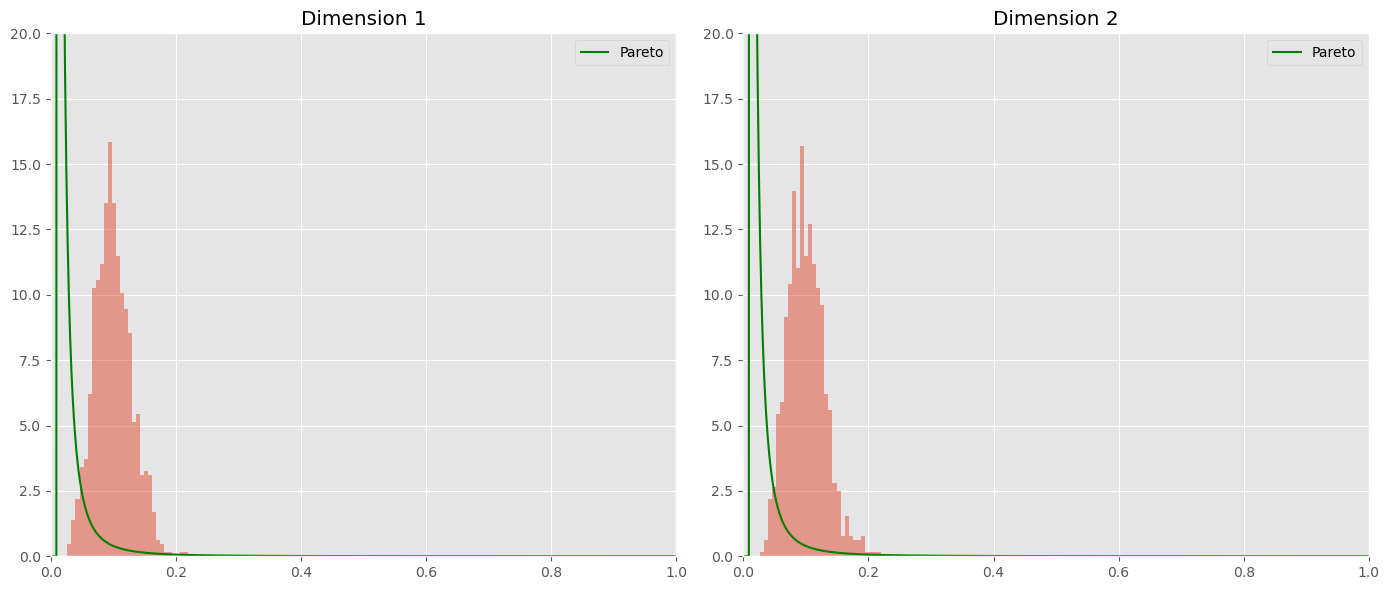

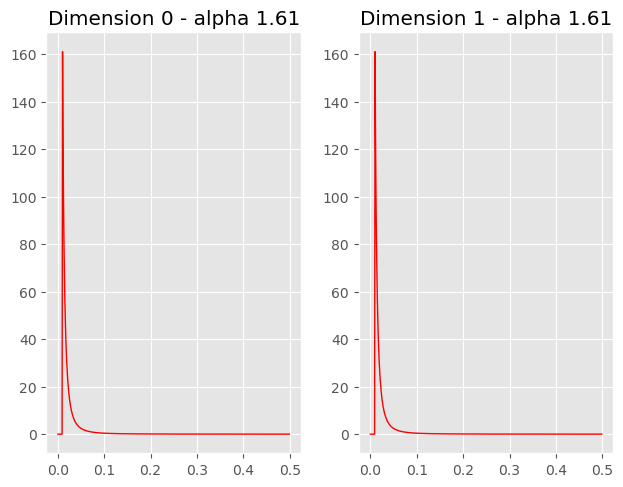

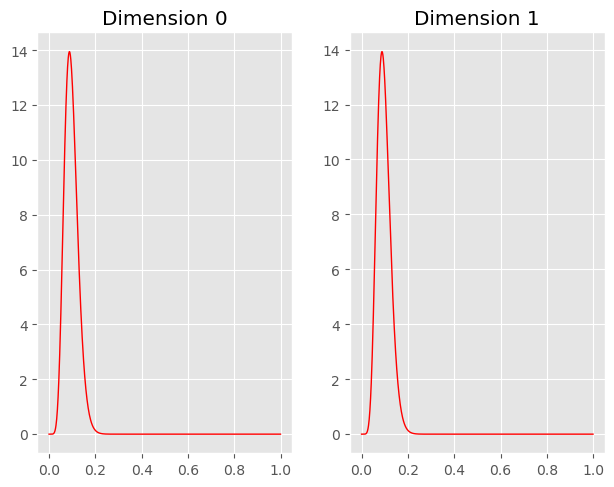

In [63]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [64]:
mb.params

{'probs_pareto': tensor([[0.0932, 0.0942]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.9818, 0.0182],
          [0.9812, 0.0188]]]),
 'alpha_pareto': tensor([[1.6100, 1.6100]]),
 'alpha_prior': tensor([[2.5015, 2.5015]]),
 'phi_beta': tensor([[0.0962, 0.0965]]),
 'k_beta': tensor([[100.0066, 100.0068]]),
 'responsib': tensor([[0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
          0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
          0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
          0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
          0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
          0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
          0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
          0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
          0.0017, 0

### One pareto-pareto component

In [65]:
N1 = 1000
seed = 123

n1=100
NV, DP = only_pareto_binomial_component(alpha_x=2, L_x=0.01, H_x=0.5, alpha_y=2, L_y=0.01, H_y=0.5, n=n1, N=N1, seed = 123)

print(DP.shape)

torch.Size([1000, 2])


In [66]:
"""
NV = torch.ones([N1, 2]) # component 1
alpha_x=2
L_x=0.01
H_x=0.5
alpha_y=2
L_y=0.01
H_y=0.5
n=100
# x-axis component 1
NV[:, 0] = BoundedPareto(scale=L_x, alpha = alpha_x, upper_limit = H_x).sample([N1]).float()
NV[:, 1] = BoundedPareto(scale=L_y, alpha = alpha_y, upper_limit = H_y).sample([N1]).float()

DP = torch.ones([N1, 2]) * n
"""

'\nNV = torch.ones([N1, 2]) # component 1\nalpha_x=2\nL_x=0.01\nH_x=0.5\nalpha_y=2\nL_y=0.01\nH_y=0.5\nn=100\n# x-axis component 1\nNV[:, 0] = BoundedPareto(scale=L_x, alpha = alpha_x, upper_limit = H_x).sample([N1]).float()\nNV[:, 1] = BoundedPareto(scale=L_y, alpha = alpha_y, upper_limit = H_y).sample([N1]).float()\n\nDP = torch.ones([N1, 2]) * n\n'

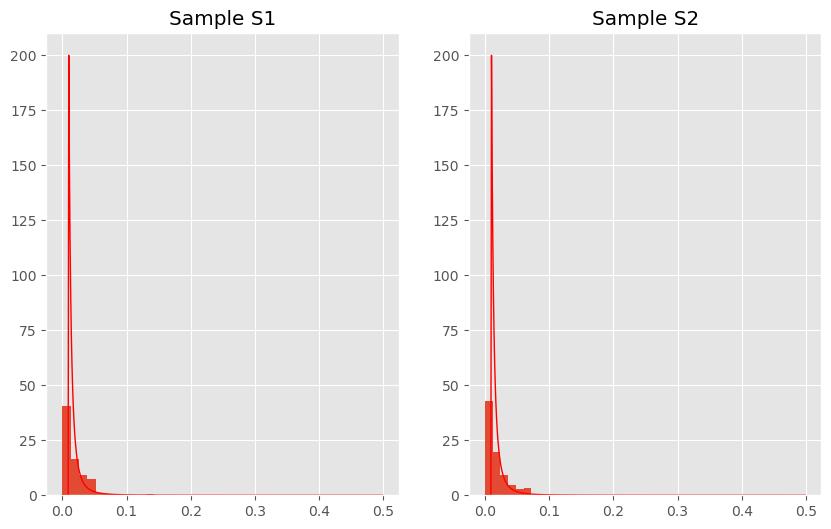

In [67]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), density = True, bins = 20)
axes[0].set_title("Sample S1")

x = np.arange(0, 0.5, 0.001)
pdf = pareto.pdf(x, 2.0, scale=0.01)
axes[0].plot(x, pdf, 'r-', lw=1)

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), density = True, bins = 20)
axes[1].set_title("Sample S2")
axes[1].plot(x, pdf, 'r-', lw=1)
plt.show()

In [68]:
labels = np.zeros(N1)

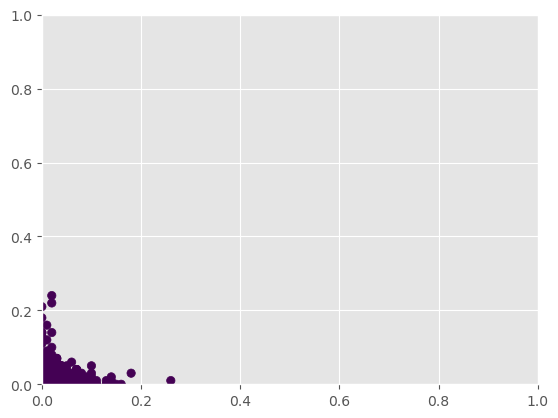

In [69]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.0195]])
Iteration 0: Loss = 11237.01953125
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0040, 2.0040]], grad_fn=<AddBackward0>)
alpha_param tensor([[1.9960, 1.9960]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0190, 0.0194]], grad_fn=<AddBackward0>)
k_beta_param tensor([[100.0685, 100.0854]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0190, 0.0194]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.3600, 0.6400],
         [0.3332, 0.6668]]], grad_fn=<DivBackward0>)


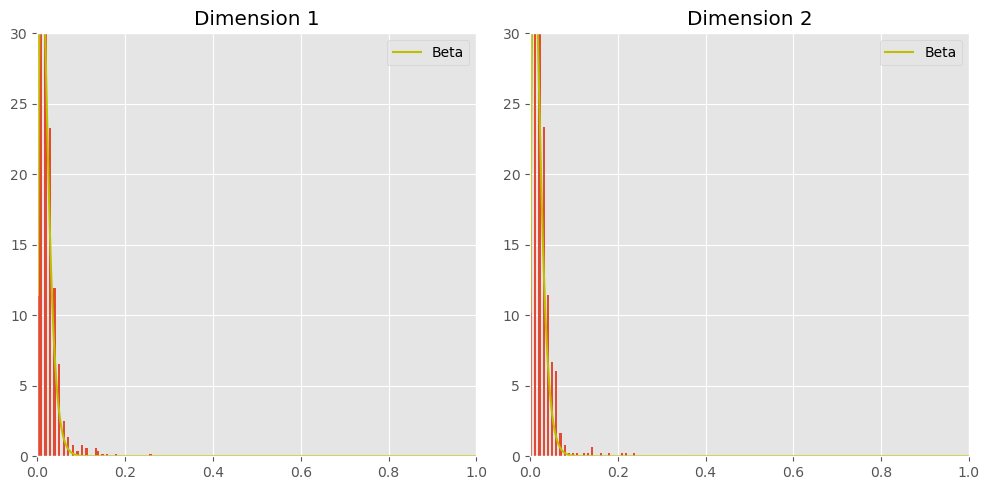

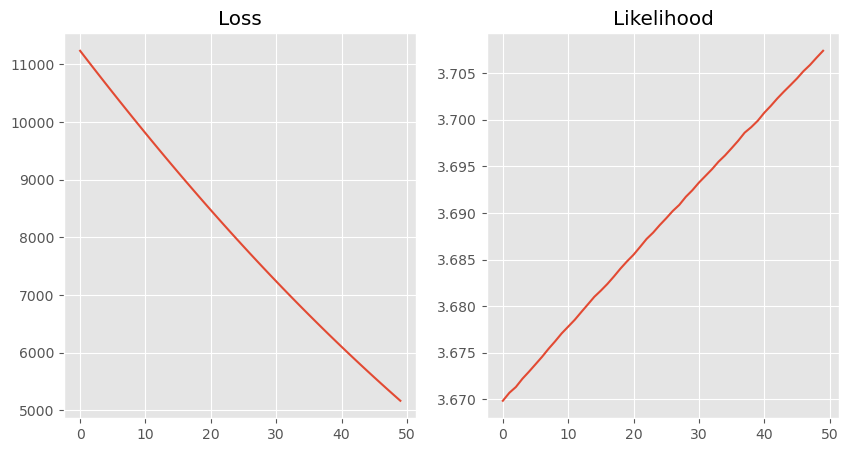

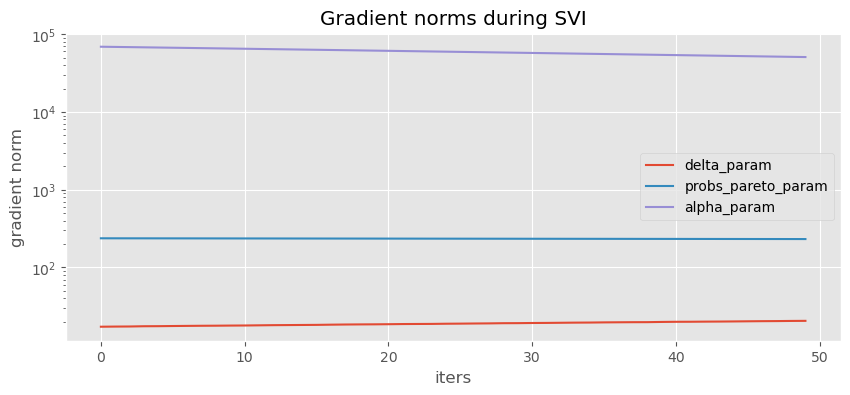

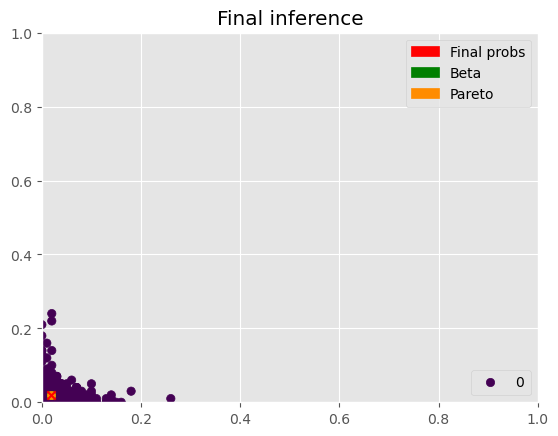

In [70]:
mb = mobster_MV(NV, DP, K = 1, seed = 53)
mb.fit(num_iter = 3000, lr = 0.001)

In [71]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0))
print(compute_likelihood(mb, beta = False, dim = 0, k = 0))

print(compute_likelihood(mb, beta = True, dim = 1, k = 0))
print(compute_likelihood(mb, beta = False, dim = 1, k = 0))

tensor(5.3008)
tensor(5.4283)
tensor(5.2877)
tensor(4.8300)


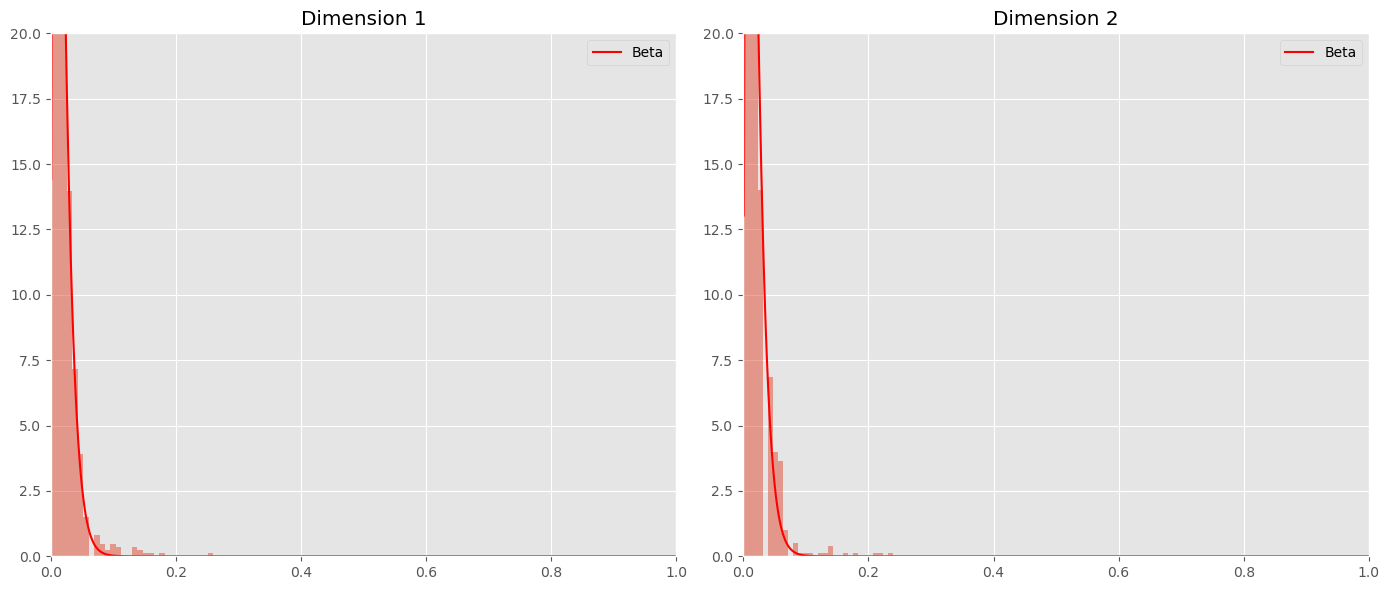

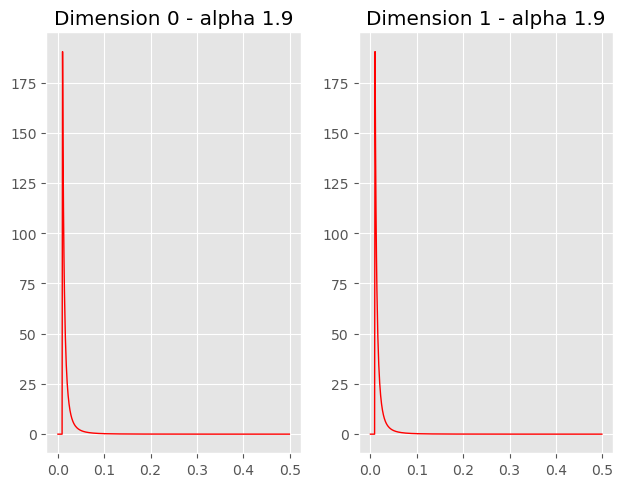

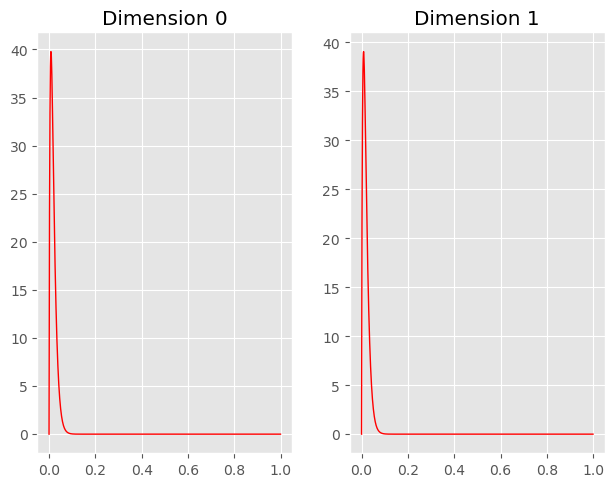

In [72]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [73]:
mb.params

{'probs_pareto': tensor([[0.0181, 0.0185]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.3834, 0.6166],
          [0.3558, 0.6442]]]),
 'alpha_pareto': tensor([[1.9044, 1.9044]]),
 'alpha_prior': tensor([[2.1011, 2.1011]]),
 'phi_beta': tensor([[0.0182, 0.0185]]),
 'k_beta': tensor([[100.0415, 100.0528]]),
 'responsib': tensor([[0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
          0.0003, 0

### One beta-pareto component

In [74]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.1
k_beta = 200
n1 = 100
NV, DP = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

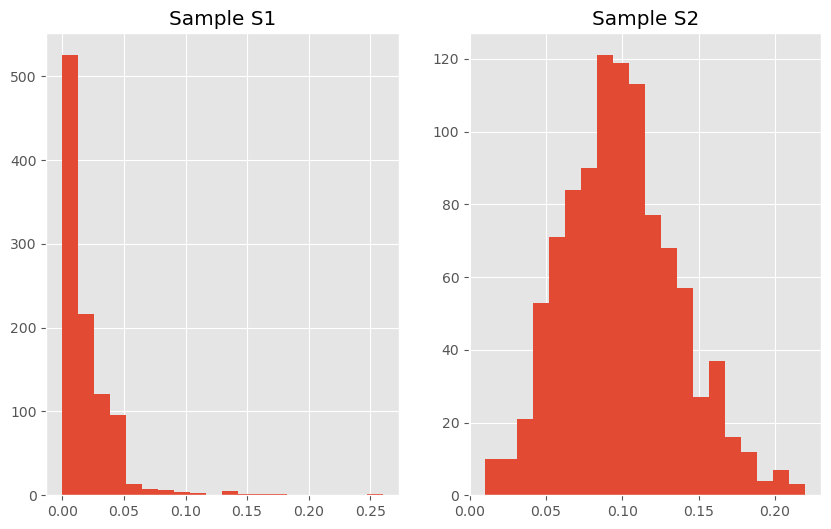

In [75]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 20)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 20)
axes[1].set_title("Sample S2")
plt.show()

In [76]:
labels = np.zeros(N1)

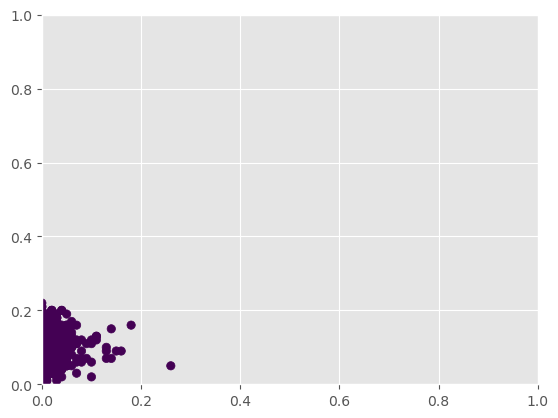

In [77]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.0191, 0.1002]])
Iteration 0: Loss = 11642.79296875
weights_param tensor([1.], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0201, 2.0201]], grad_fn=<AddBackward0>)
alpha_param tensor([[1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.0189, 0.0994]], grad_fn=<AddBackward0>)
k_beta_param tensor([[100.1727, 100.6135]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.0189, 0.0994]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.0473, 0.9527],
         [0.0509, 0.9491]]], grad_fn=<DivBackward0>)


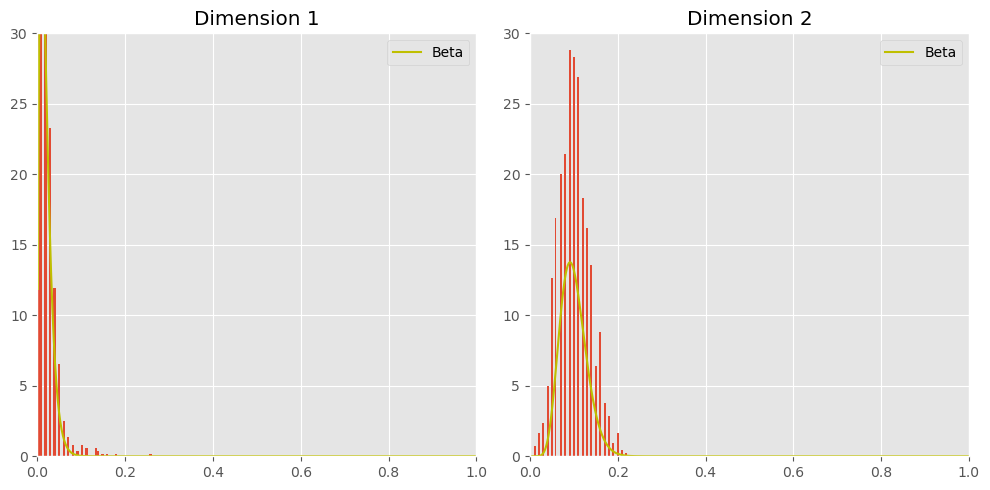

Iteration 200: Loss = -2941.65380859375
Iteration 400: Loss = -3049.43310546875
phi_beta [[0.00874462 0.0948109 ]]
delta [[[0.8772353  0.12276476]
  [0.8668556  0.13314435]]]


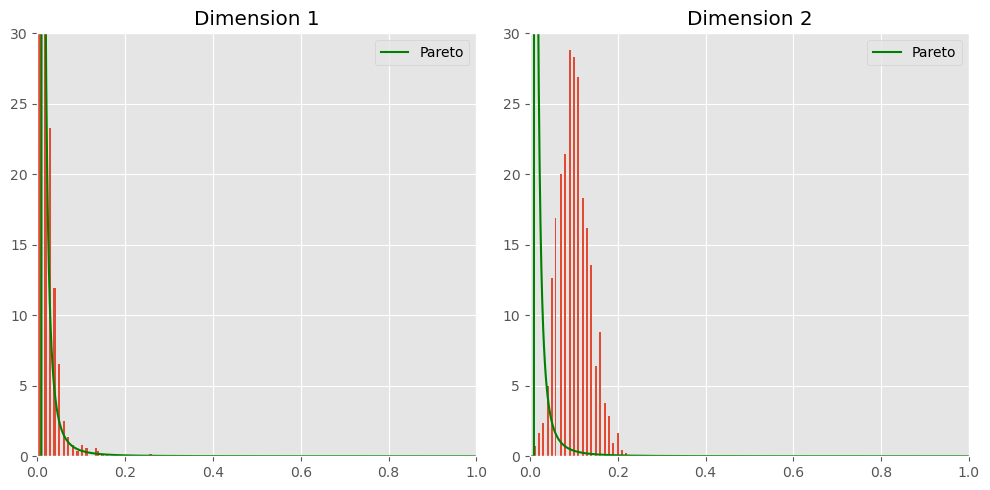

Iteration 600: Loss = -3067.03759765625
Iteration 800: Loss = -3072.57373046875
phi_beta [[0.00814389 0.0947865 ]]
delta [[[0.9676753  0.03232472]
  [0.96788275 0.03211727]]]


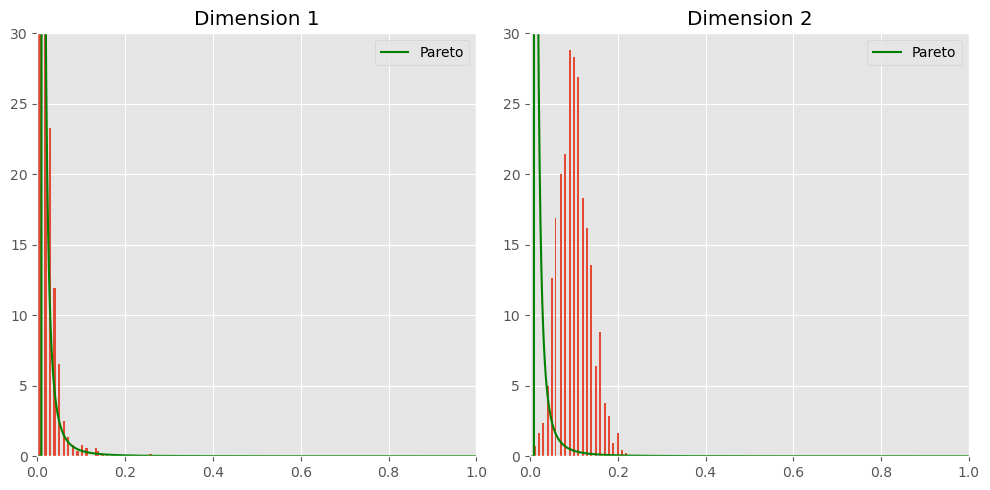

Iteration 1000: Loss = -3075.103271484375
Iteration 1200: Loss = -3076.500244140625
phi_beta [[0.00788682 0.09478249]]
delta [[[0.9844232  0.01557682]
  [0.98497355 0.01502645]]]


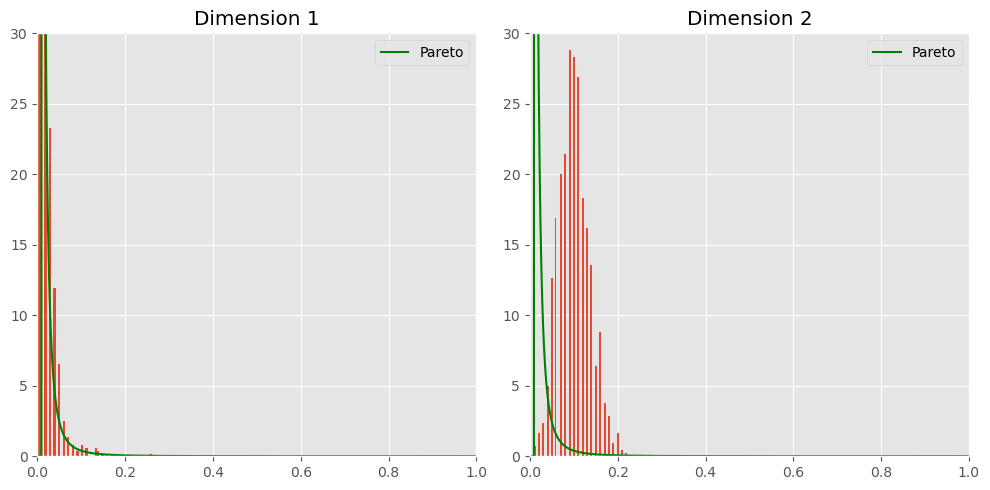

Iteration 1400: Loss = -3077.365478515625
Iteration 1600: Loss = -3077.942138671875
phi_beta [[0.00772232 0.09478114]]
delta [[[0.9907635  0.00923648]
  [0.9912348  0.00876514]]]


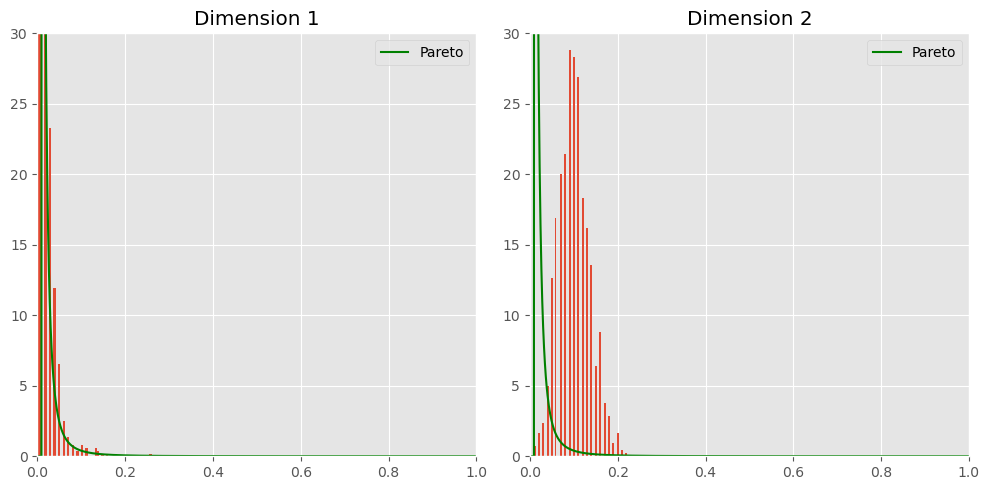

Iteration 1800: Loss = -3078.348388671875
Iteration 2000: Loss = -3078.649658203125
phi_beta [[0.00760024 0.09478043]]
delta [[[0.9939219  0.00607814]
  [0.994296   0.00570395]]]


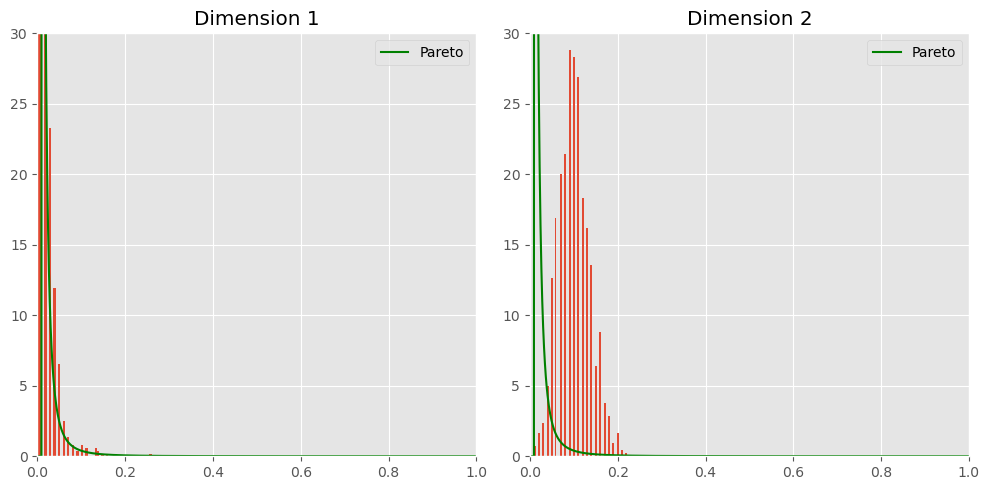

Iteration 2200: Loss = -3078.87890625
Iteration 2400: Loss = -3079.055419921875
phi_beta [[0.0075022  0.09477995]]
delta [[[0.99574476 0.0042552 ]
  [0.99604034 0.00395966]]]


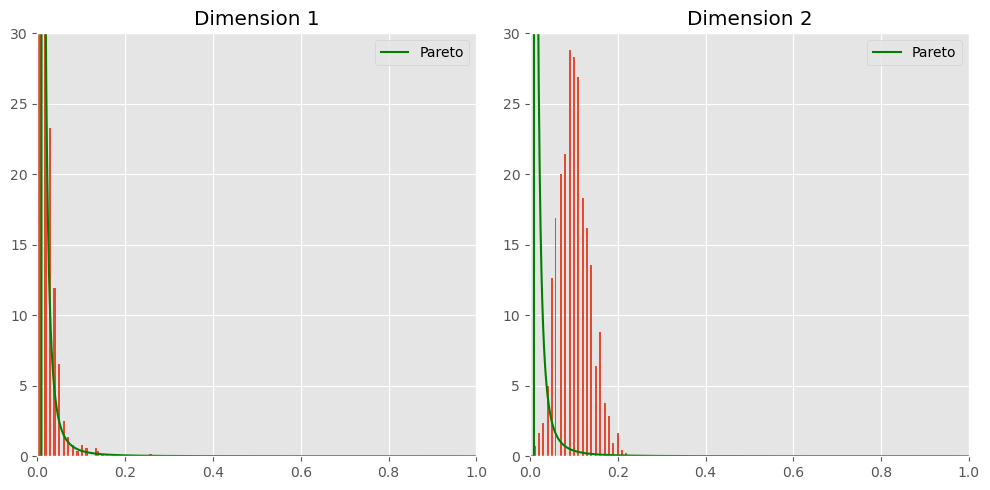

Iteration 2600: Loss = -3079.198974609375
Iteration 2800: Loss = -3079.3134765625
phi_beta [[0.00741951 0.09477986]]
delta [[[0.9968978  0.00310214]
  [0.9971329  0.00286707]]]


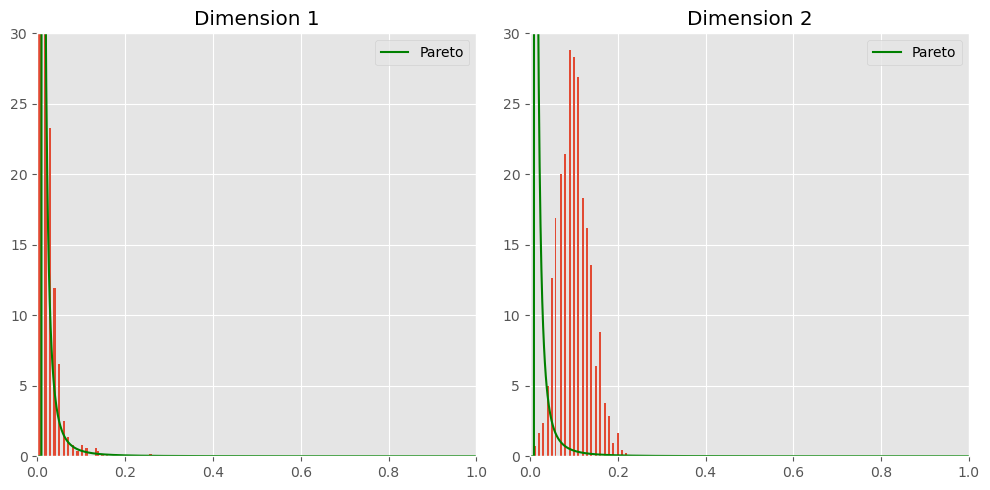

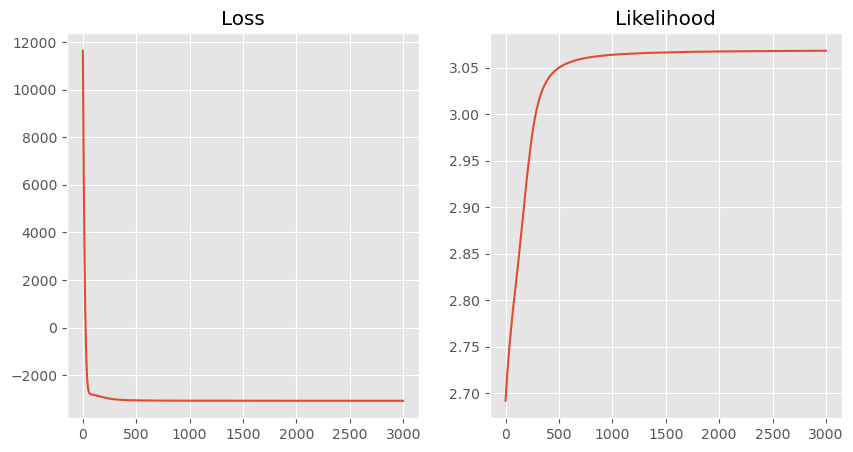

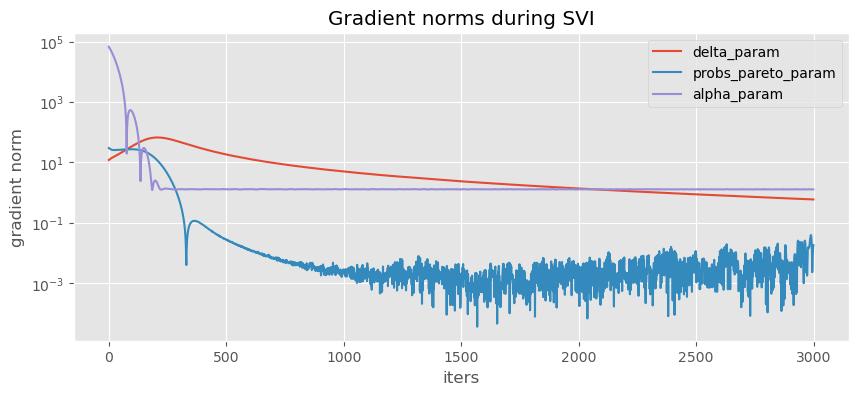

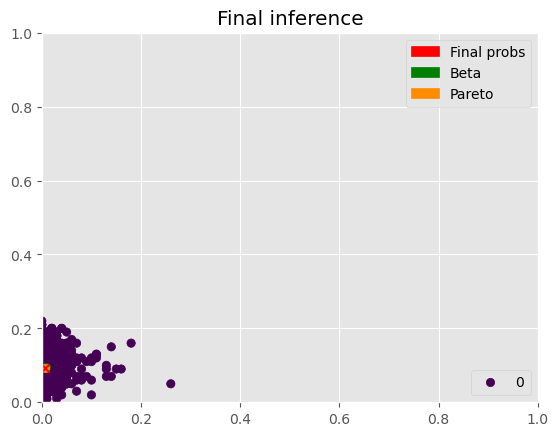

In [78]:
mb = mobster_MV(NV, DP, K = 1, seed = 13)
mb.fit(num_iter = 3000, lr = 0.005)

In [79]:
print(compute_likelihood(mb, beta = True, dim = 0, k = 0)) # x axis, beta
print(compute_likelihood(mb, beta = False, dim = 0, k = 0)) # x axis, pareto
print(compute_likelihood(mb, beta = True, dim = 1, k = 0)) # y axis, beta
print(compute_likelihood(mb, beta = False, dim = 1, k = 0)) # y axis, pareto

tensor(5.4330)
tensor(5.4344)
tensor(4.2991)
tensor(3.4142)


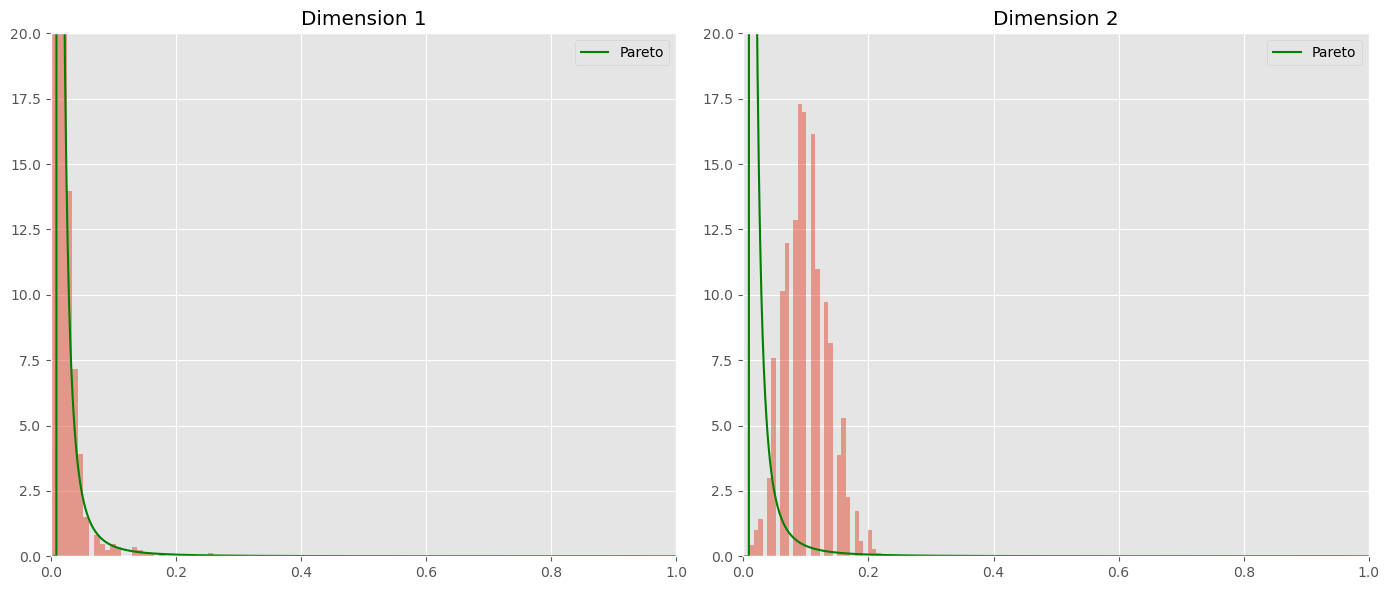

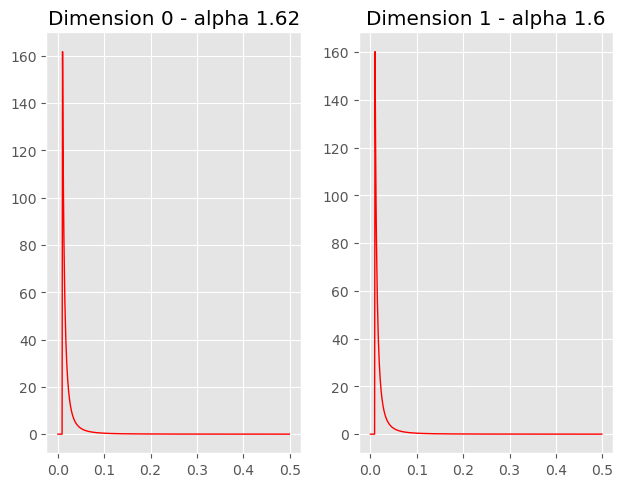

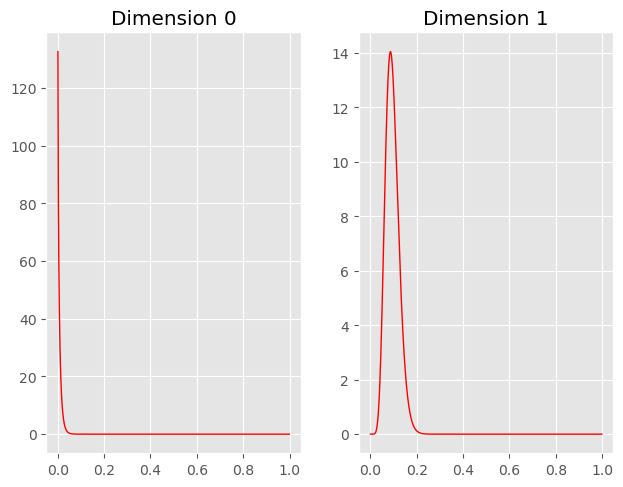

In [80]:
plot_marginals(mb)
# plot_deltas(mb)
plot_paretos_1(mb)
plot_betas_1(mb)

In [81]:
mb.params

{'probs_pareto': tensor([[0.0065, 0.0921]]),
 'weights': tensor([1.]),
 'delta': tensor([[[0.9973, 0.0027],
          [0.9975, 0.0025]]]),
 'alpha_pareto': tensor([[1.6171, 1.6022]]),
 'alpha_prior': tensor([[2.5192, 2.4821]]),
 'phi_beta': tensor([[0.0074, 0.0948]]),
 'k_beta': tensor([[99.9811, 99.9553]]),
 'responsib': tensor([[0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
          0.0013, 0.0

### 2 beta-pareto components

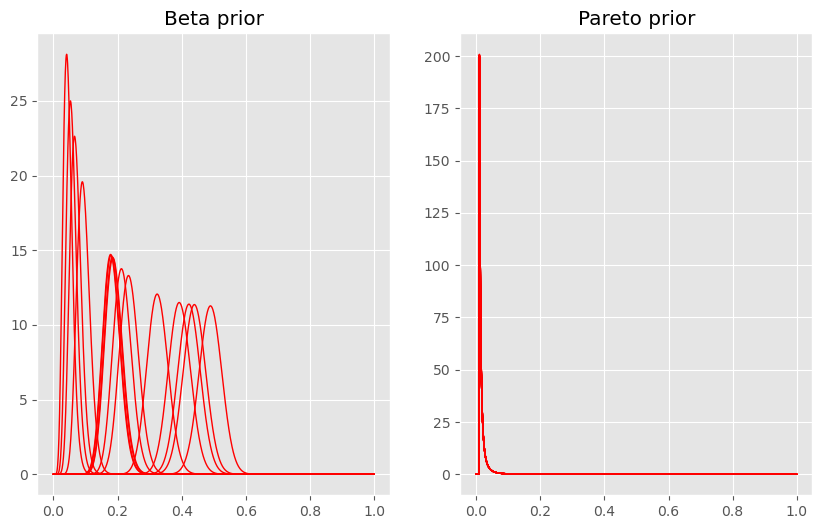

In [114]:
def plot_priors():
    # fig.tight_layout()
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
    x = np.arange(0,1,0.001)
    for _ in range(15):
        phi_beta = dist.Uniform(0., 0.51).sample().numpy()
        k_beta = dist.Normal(200, 0.5).sample().numpy()
        a_beta = phi_beta * k_beta
        b_beta = (1-phi_beta) * k_beta
        pdf = beta.pdf(x, a_beta, b_beta)
        axes[0].plot(x, pdf, 'r-', lw=1)
        axes[0].set_title("Beta prior")
    # plt.show()
    x = np.arange(0,1,0.001)
    for _ in range(25):
        alpha = dist.Normal(2, 0.005).sample().numpy()
        # alpha_mu = dist.Uniform(0.,1.).sample()
        # alpha = dist.LogNormal(alpha_mu, 0.3).sample().numpy()
        # print(alpha)            
        pdf = pareto.pdf(x, alpha, scale = 0.01)
        axes[1].plot(x, pdf, 'r-', lw=1)
        axes[1].set_title("Pareto prior")
    plt.show()
plot_priors()

In [115]:
N1 = 1000
N2 = 500
seed = 123
# Sample S1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.2
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Sample S2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
print(NV.shape)
DP = torch.concat((DP1,DP2))
print(DP.shape)

torch.Size([1500, 2])
torch.Size([1500, 2])


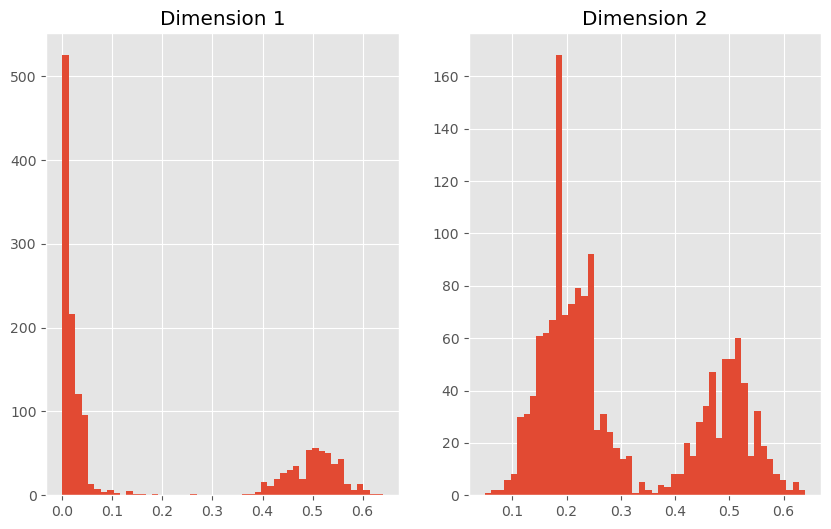

In [116]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [117]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))

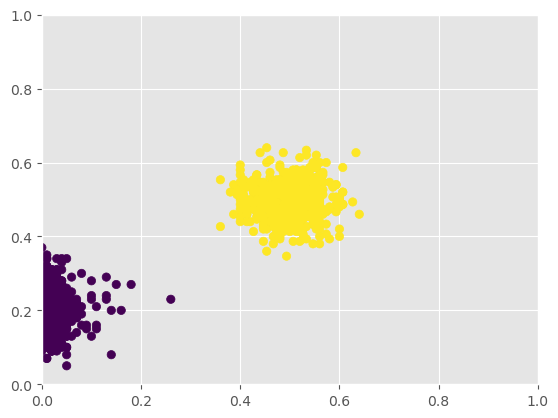

In [118]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])


Text(0.5, 1.0, 'kmeans')

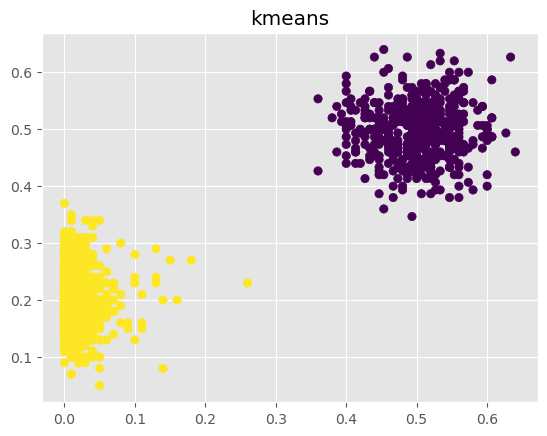

In [119]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.title("kmeans")

kmeans_centers:  tensor([[0.5020, 0.4978],
        [0.0191, 0.2010]])
Iteration 0: Loss = 14089909.0
weights_param tensor([0.5203, 0.4797], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0201, 2.0201],
        [2.0201, 2.0201]], grad_fn=<AddBackward0>)
alpha_param tensor([[1.9801, 1.9801],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.5019, 0.4977],
        [0.0189, 0.2003]], grad_fn=<AddBackward0>)
k_beta_param tensor([[101.0048, 101.0041],
        [ 99.0064,  99.0051]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.5021, 0.4977],
        [0.0189, 0.2007]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.2465, 0.7535],
         [0.5738, 0.4262]],

        [[0.1158, 0.8842],
         [0.8698, 0.1302]]], grad_fn=<DivBackward0>)


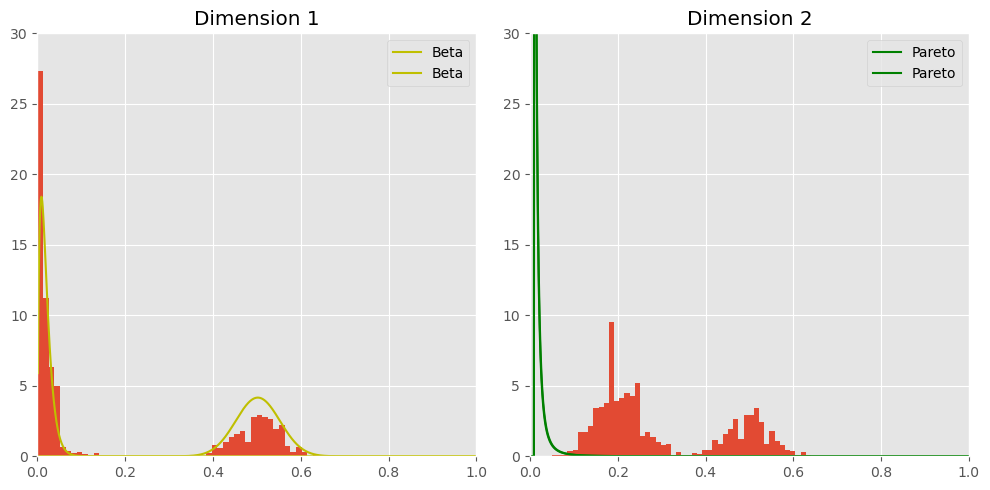

Iteration 200: Loss = 13814596.0
Iteration 400: Loss = 13806829.0
phi_beta [[0.4919325  0.49880585]
 [0.02773768 0.2018294 ]]
delta [[[0.6087043  0.39129564]
  [0.5965088  0.40349114]]

 [[0.7236355  0.2763645 ]
  [0.43547496 0.564525  ]]]


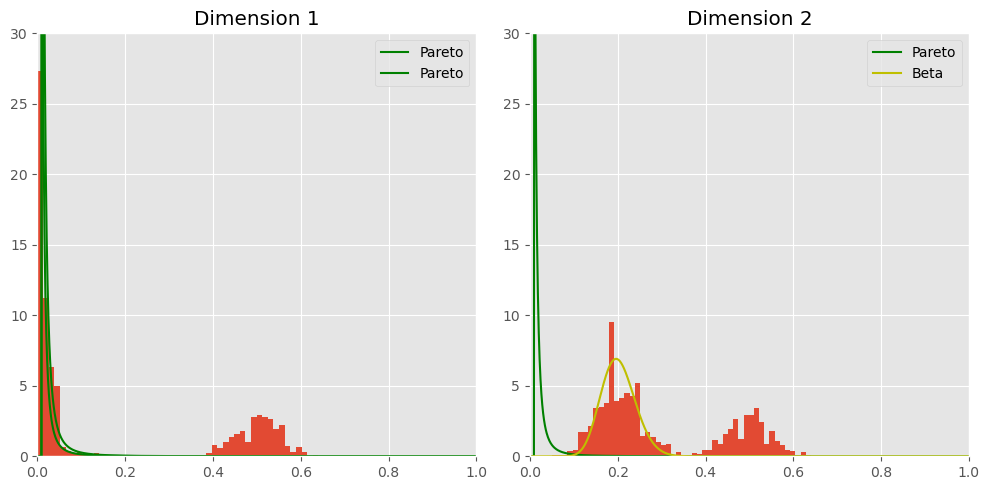

Iteration 600: Loss = 13806603.0
Iteration 800: Loss = 13806516.0
phi_beta [[0.49073967 0.4988068 ]
 [0.02803383 0.20180206]]
delta [[[0.61241657 0.38758346]
  [0.5966378  0.4033622 ]]

 [[0.72917295 0.27082705]
  [0.38480994 0.6151901 ]]]


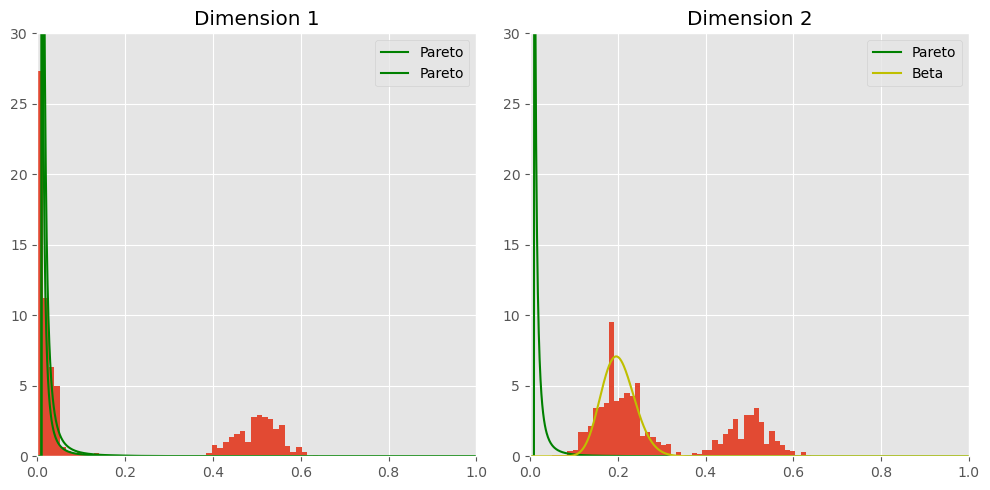

Iteration 1000: Loss = 13806641.0
Iteration 1200: Loss = 13806622.0
phi_beta [[0.4903247  0.49880362]
 [0.02803491 0.20180221]]
delta [[[0.6124209  0.38757908]
  [0.5966492  0.4033507 ]]

 [[0.7291625  0.27083746]
  [0.3836514  0.6163486 ]]]


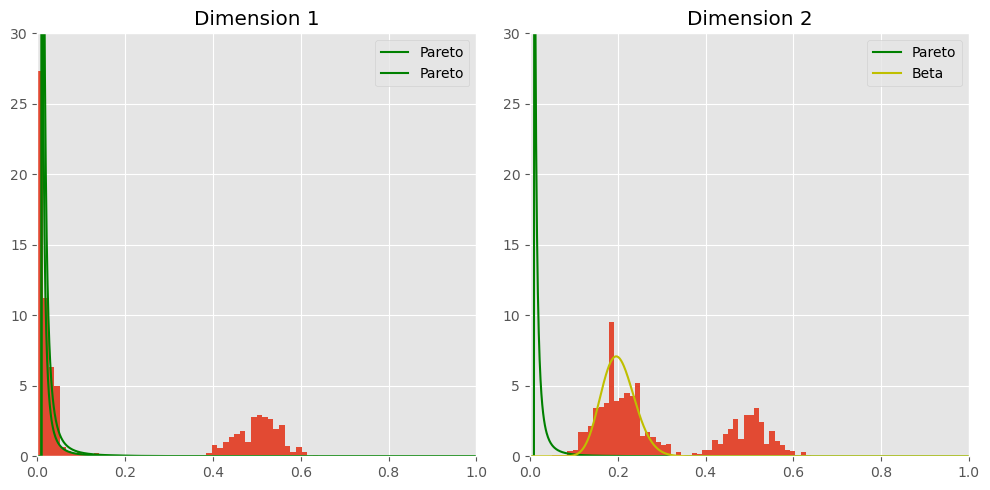

Iteration 1400: Loss = 13806560.0
Iteration 1600: Loss = 13806576.0
phi_beta [[0.4901038  0.49880183]
 [0.02803694 0.20180267]]
delta [[[0.61220783 0.3877922 ]
  [0.59652704 0.40347296]]

 [[0.72921944 0.27078056]
  [0.38359973 0.61640024]]]


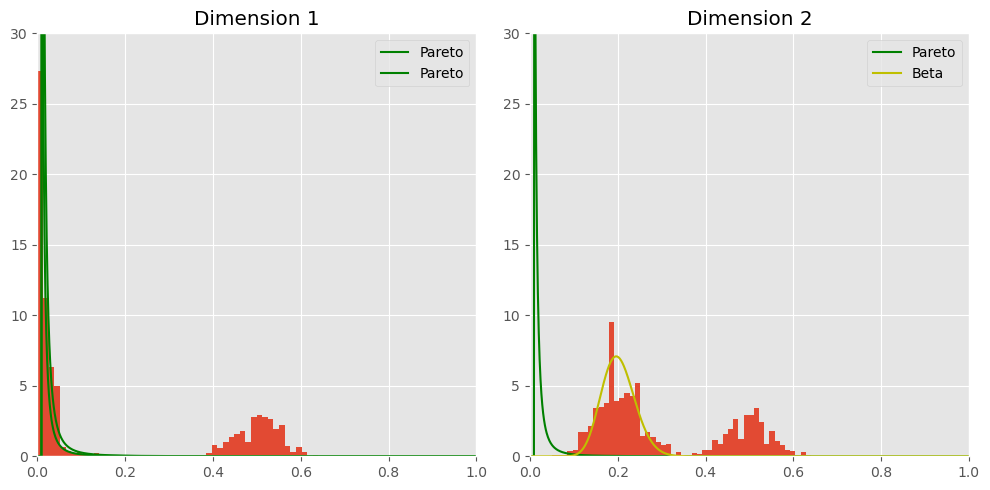

Iteration 1800: Loss = 13806647.0
Iteration 2000: Loss = 13806635.0
phi_beta [[0.4899556  0.4988031 ]
 [0.02803614 0.20180178]]
delta [[[0.61213994 0.38786006]
  [0.59642905 0.40357095]]

 [[0.7291916  0.2708084 ]
  [0.38357887 0.61642116]]]


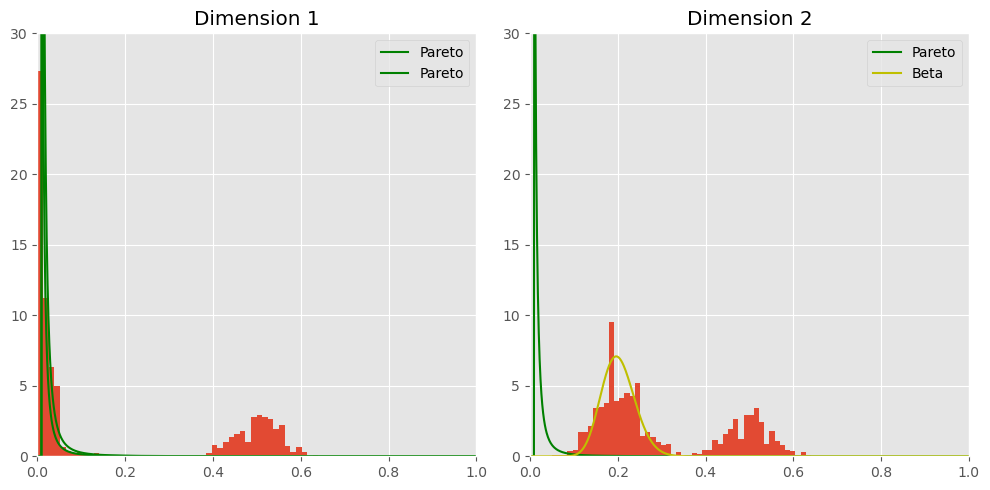

Iteration 2200: Loss = 13806549.0
Iteration 2400: Loss = 13806524.0
phi_beta [[0.48984733 0.49880648]
 [0.02803195 0.20180568]]
delta [[[0.61214495 0.38785508]
  [0.59652925 0.40347078]]

 [[0.729142   0.270858  ]
  [0.38346326 0.6165368 ]]]


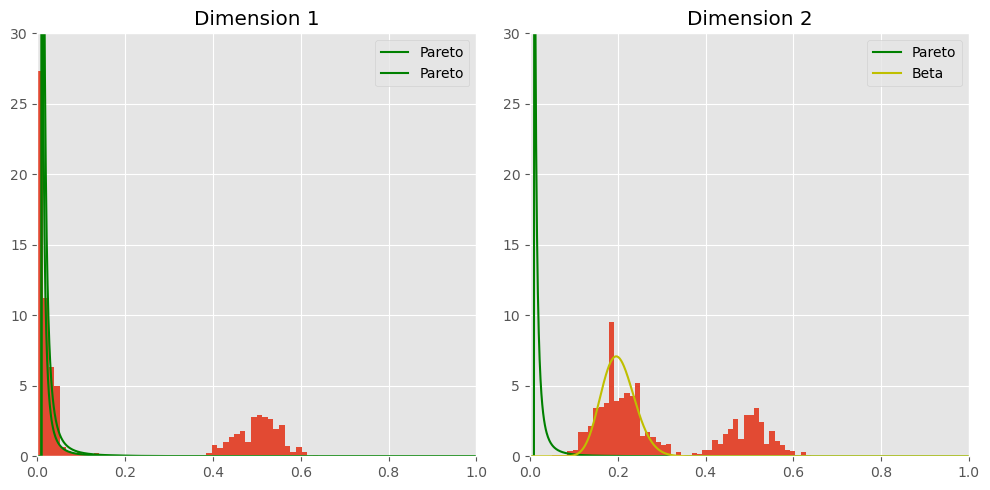

Iteration 2600: Loss = 13806565.0
Iteration 2800: Loss = 13806501.0
phi_beta [[0.48976925 0.4988126 ]
 [0.02803534 0.20180555]]
delta [[[0.6121591  0.38784093]
  [0.59685856 0.40314147]]

 [[0.7291846  0.27081537]
  [0.38352725 0.6164728 ]]]


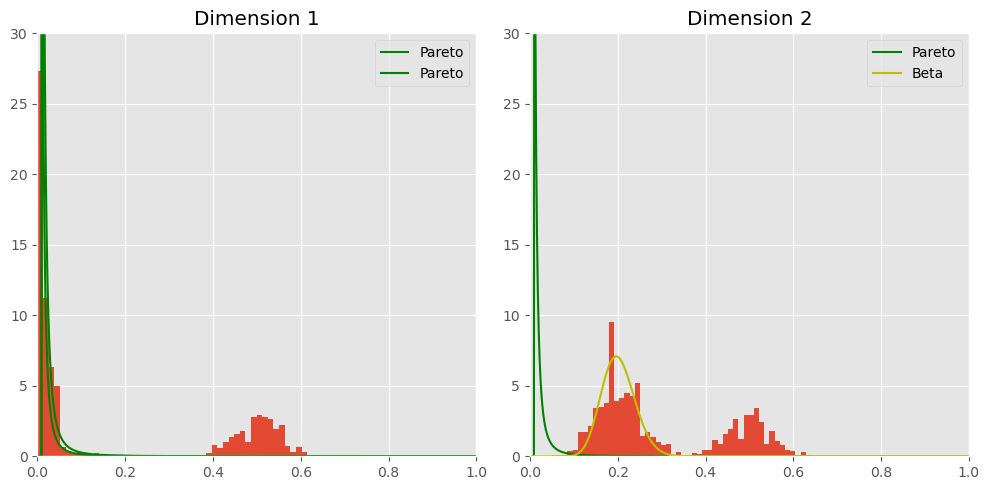

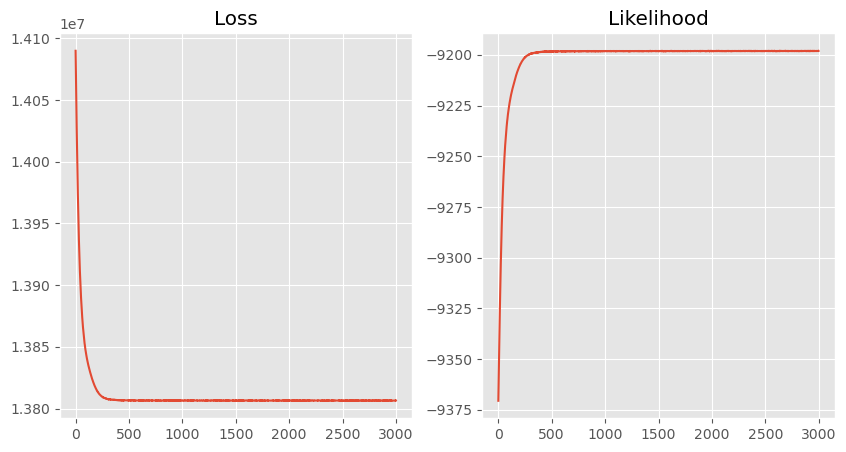

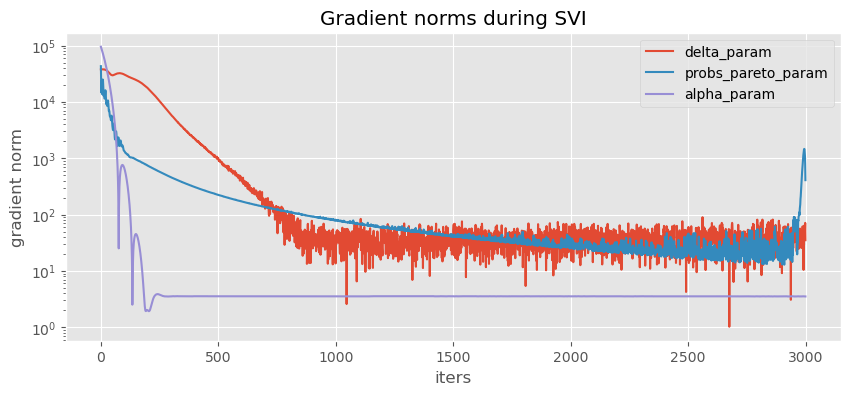

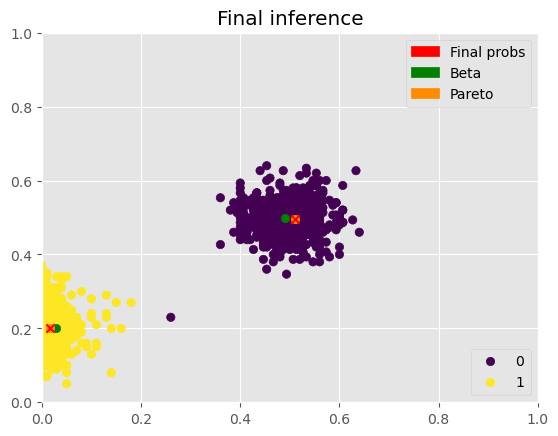

In [120]:
mb = mobster_MV(NV, DP, K = 2, seed = 24)
mb.fit(num_iter = 3000, lr = 0.005)

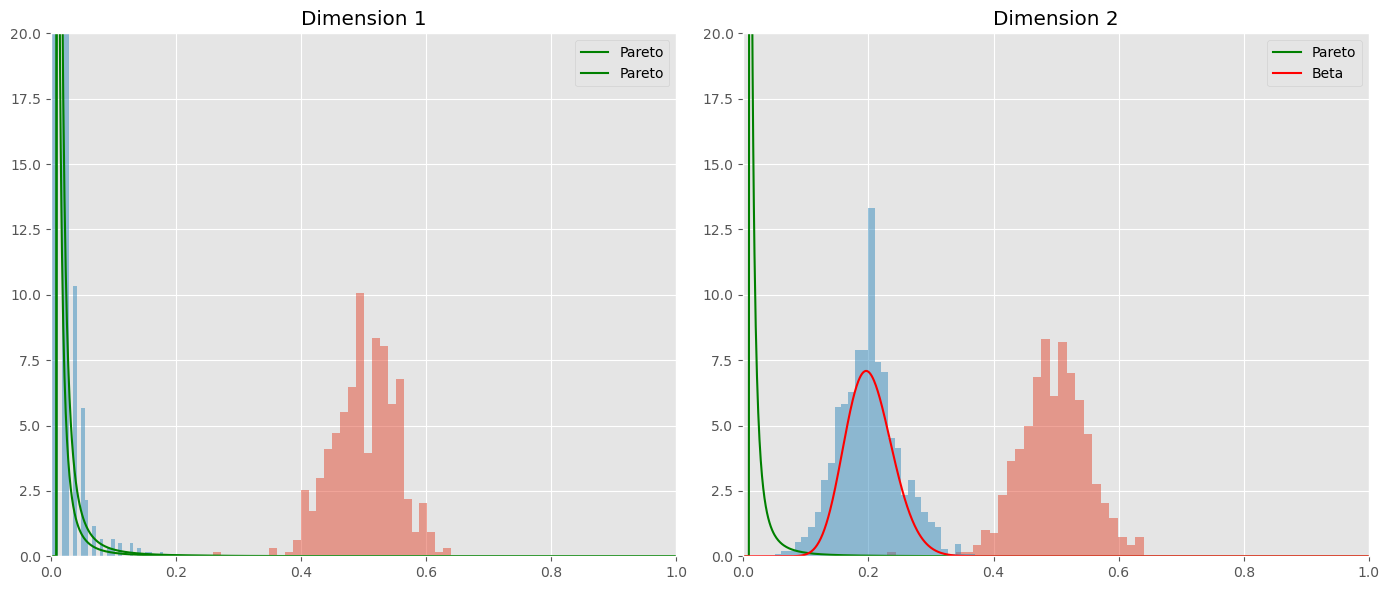

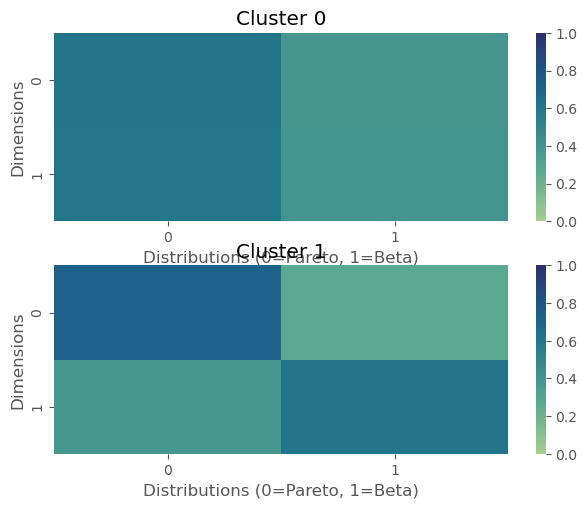

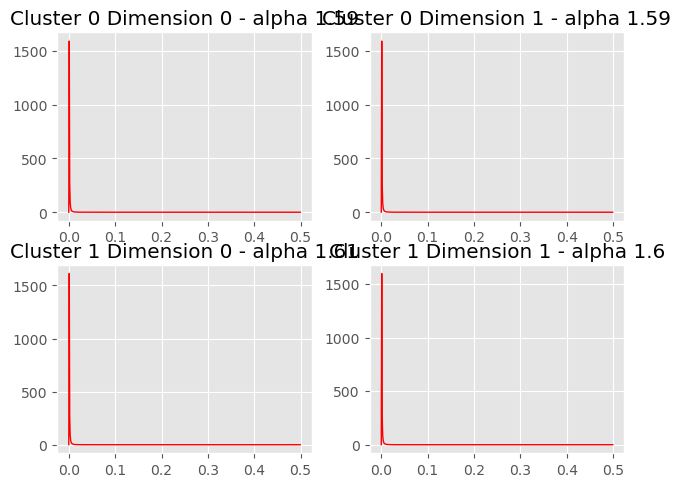

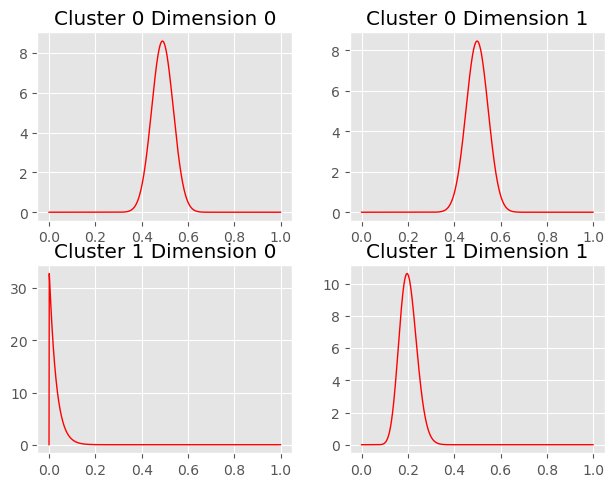

In [121]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [122]:
mb.params

{'probs_pareto': tensor([[0.5097, 0.4971],
         [0.0155, 0.1998]]),
 'weights': tensor([0.3333, 0.6667]),
 'delta': tensor([[[0.6120, 0.3880],
          [0.5968, 0.4032]],
 
         [[0.7292, 0.2708],
          [0.3834, 0.6166]]]),
 'alpha_pareto': tensor([[1.5927, 1.5929],
         [1.6122, 1.5979]]),
 'alpha_prior': tensor([[2.4587, 2.4590],
         [2.5070, 2.4715]]),
 'phi_beta': tensor([[0.4897, 0.4988],
         [0.0280, 0.2018]]),
 'k_beta': tensor([[116.8092, 112.8349],
         [ 36.1010, 113.0178]]),
 'responsib': tensor([[9.5844e-38, 2.2393e-35, 1.6427e-33,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00]]),
 'cluster_assignments': tensor([1, 1, 1,  ..., 0, 0, 0])}

### 4 beta-pareto components

In [91]:
N1 = 500
N2 = 300
N3 = 200
N4 = 200
N5 = 200
seed = 123
# Component 1
alpha_pareto = 2
L_pareto = 0.01
H_pareto = 0.3
phi_beta = 0.5
k_beta = 200
n1 = 100
NV1, DP1 = pareto_binomial_component(alpha=alpha_pareto, L=L_pareto, H=H_pareto, phi_beta = phi_beta, k_beta = k_beta, n=n1, N=N1, seed = seed)

# Component 2
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.5
k_beta_y= 250
n2=150
NV2, DP2 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n2, N=N2, seed=seed)
NV = torch.concat((NV1,NV2))
DP = torch.concat((DP1,DP2))

# Component 3
phi_beta_x = 0.5
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n3=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n3, N=N3, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))

# Component 4
phi_beta_x = 0.3
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n4=150
NV4, DP4 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n4, N=N4, seed=seed)
NV = torch.concat((NV,NV4))
print(NV.shape)
DP = torch.concat((DP,DP4))
print(DP.shape)

# Component 5
phi_beta_x = 0.1
k_beta_x = 250
phi_beta_y = 0.0001
k_beta_y= 250
n5=150
NV3, DP3 = beta_binomial_component(phi_beta_x = phi_beta_x, k_beta_x = k_beta_x, phi_beta_y = phi_beta_y, k_beta_y= k_beta_y, n=n5, N=N5, seed=seed)
NV = torch.concat((NV,NV3))
DP = torch.concat((DP,DP3))


torch.Size([1200, 2])
torch.Size([1200, 2])


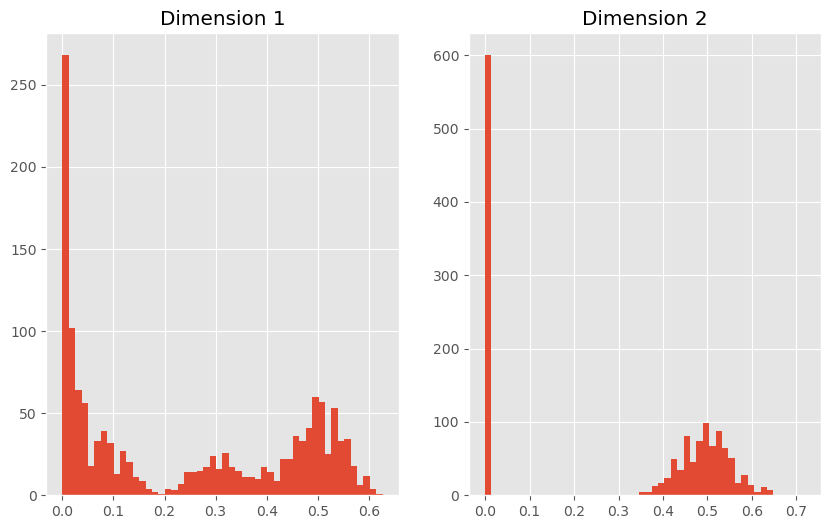

In [92]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Dimension 1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Dimension 2")
plt.show()

In [93]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels = np.concatenate((labels_1, labels_2))
labels_3 = np.ones(N3)*2
labels = np.concatenate((labels, labels_3))
labels_4 = np.ones(N3)*3
labels = np.concatenate((labels, labels_4))
labels_5 = np.ones(N3)*4
labels = np.concatenate((labels, labels_5))

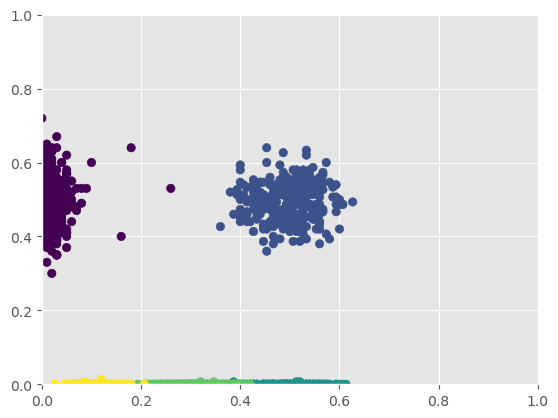

In [94]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

kmeans_centers:  tensor([[4.9805e-01, 6.7055e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [1.0017e-01, 9.9927e-05],
        [3.0304e-01, 9.8795e-05]])
inertia:  4.6338300704956055


(0.0, 1.0)

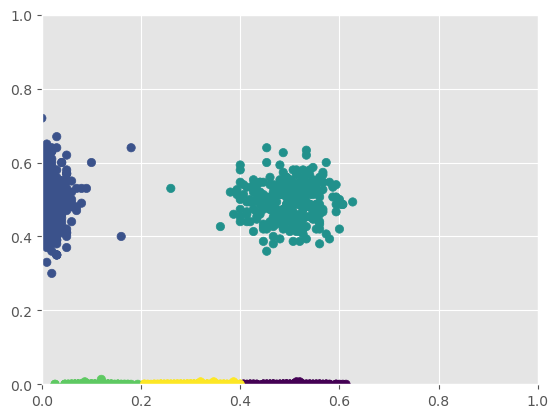

In [95]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)
print("inertia: ", kmeans.inertia_) # the lower the better

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])

kmeans_centers:  tensor([[1.0017e-01, 9.9927e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [5.0059e-01, 6.8814e-05],
        [3.0538e-01, 9.6411e-05]])
inertia:  4.6314496994018555


(0.0, 1.0)

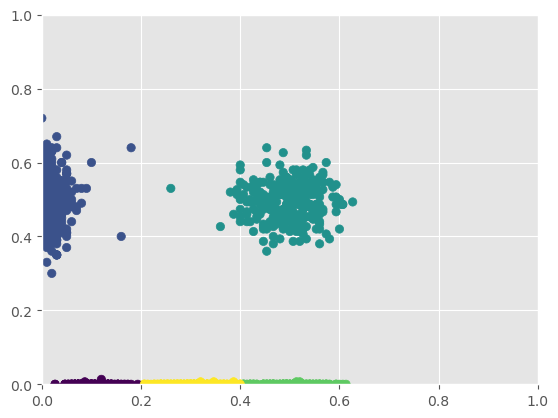

In [96]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=45, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)
print("inertia: ", kmeans.inertia_) # the lower the better

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)
plt.xlim([0,1])
plt.ylim([0,1])

kmeans_centers:  tensor([[4.9805e-01, 6.7055e-05],
        [1.8076e-02, 4.9715e-01],
        [4.9825e-01, 4.9501e-01],
        [1.0017e-01, 9.9927e-05],
        [3.0304e-01, 9.8765e-05]])
Iteration 0: Loss = 12949265.0
weights_param tensor([0.1769, 0.2397, 0.0278, 0.2602, 0.2953], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0201, 2.0201],
        [2.0201, 2.0201],
        [2.0201, 2.0201],
        [2.0201, 2.0201],
        [2.0201, 2.0201]], grad_fn=<AddBackward0>)
alpha_param tensor([[1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801],
        [1.9801, 1.9801]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[4.9816e-01, 6.6388e-05],
        [1.8250e-02, 4.9728e-01],
        [4.9814e-01, 4.9486e-01],
        [1.0097e-01, 1.0093e-04],
        [3.0426e-01, 9.7782e-05]], grad_fn=<AddBackward0>)
k_beta_param tensor([[101.0047, 100.5036],
        [101.0023,  99.0052],
        [101.0038, 101.0042],
        [101.0041, 100.3612],
        [10

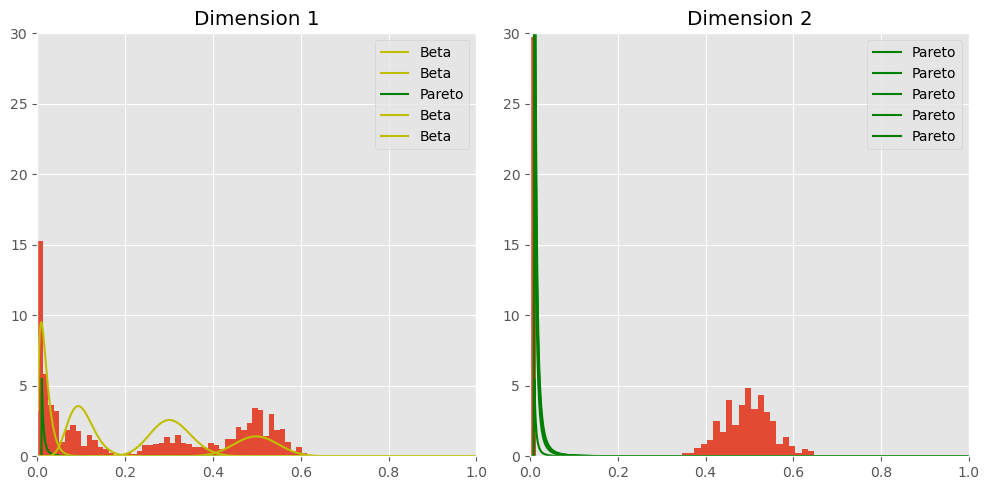

Iteration 200: Loss = 12239664.0
Iteration 400: Loss = 12123624.0
phi_beta [[5.02145112e-01 1.74566085e-05]
 [2.56629270e-02 5.05718231e-01]
 [4.80430603e-01 4.92327780e-01]
 [1.10305637e-01 1.19859826e-04]
 [3.40901911e-01 3.89155139e-05]]
delta [[[0.8714799  0.12852   ]
  [0.90460634 0.09539367]]

 [[0.6663867  0.33361328]
  [0.51956195 0.48043805]]

 [[0.66242033 0.3375797 ]
  [0.63871676 0.3612832 ]]

 [[0.53949666 0.46050334]
  [0.15230224 0.84769773]]

 [[0.47401944 0.52598053]
  [0.96519697 0.03480301]]]


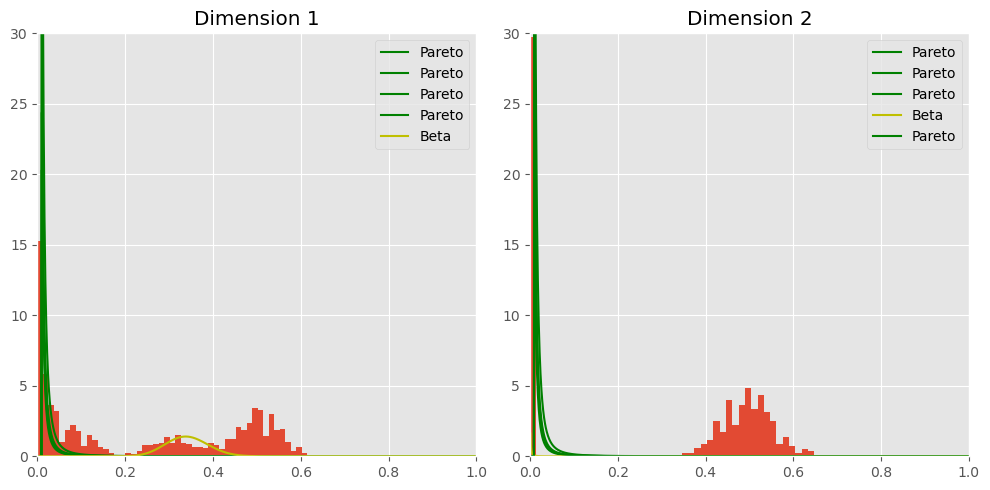

Iteration 600: Loss = 12120335.0
Iteration 800: Loss = 12120192.0
phi_beta [[4.9289516e-01 1.0669545e-05]
 [2.6368830e-02 5.0369734e-01]
 [4.7842142e-01 4.9232998e-01]
 [1.1022697e-01 1.1480482e-04]
 [3.3822122e-01 2.8452376e-05]]
delta [[[0.9087939  0.09120602]
  [0.943784   0.05621595]]

 [[0.6830048  0.31699523]
  [0.47222    0.52778   ]]

 [[0.66460955 0.33539045]
  [0.6386952  0.36130482]]

 [[0.54002714 0.4599728 ]
  [0.08034112 0.9196589 ]]

 [[0.45980984 0.5401901 ]
  [0.9831935  0.01680653]]]


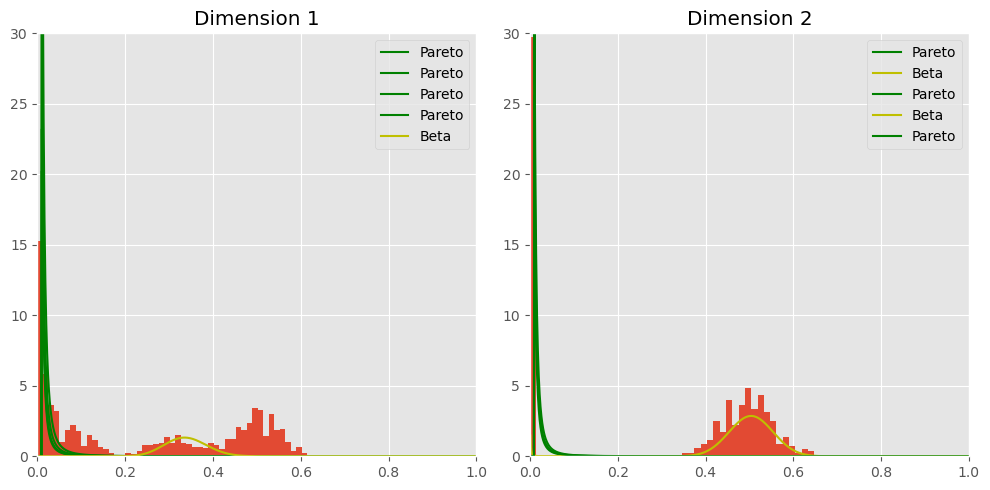

Iteration 1000: Loss = 12119978.0
Iteration 1200: Loss = 12119851.0
phi_beta [[4.6496496e-01 7.8521989e-06]
 [2.6383530e-02 5.0342757e-01]
 [4.7778398e-01 4.9233389e-01]
 [1.0992993e-01 1.1278312e-04]
 [3.3299118e-01 2.3448683e-05]]
delta [[[0.8888845  0.11111554]
  [0.9615374  0.03846261]]

 [[0.6833035  0.3166965 ]
  [0.4684943  0.5315057 ]]

 [[0.66405237 0.3359477 ]
  [0.6388501  0.36114994]]

 [[0.5417531  0.45824692]
  [0.0517706  0.9482294 ]]

 [[0.4521761  0.5478239 ]
  [0.98947656 0.0105234 ]]]


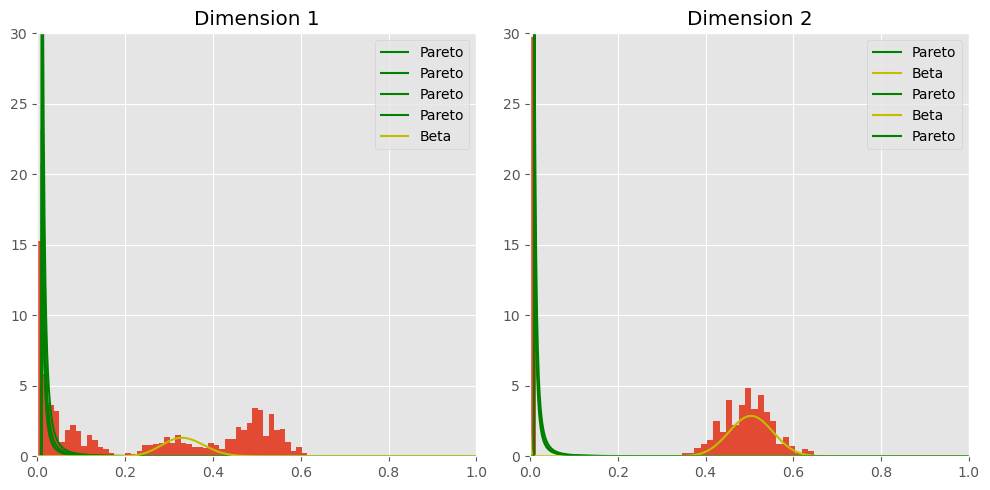

Iteration 1400: Loss = 12119725.0
Iteration 1600: Loss = 12119621.0
phi_beta [[4.4911230e-01 6.2516401e-06]
 [2.6386054e-02 5.0342453e-01]
 [4.7745574e-01 4.9233022e-01]
 [1.0921751e-01 1.1191714e-04]
 [3.2203645e-01 2.0368981e-05]]
delta [[[0.82207954 0.1779205 ]
  [0.97215444 0.02784559]]

 [[0.6833712  0.31662887]
  [0.46835163 0.5316484 ]]

 [[0.66369194 0.33630806]
  [0.6387997  0.36120024]]

 [[0.5473272  0.45267284]
  [0.03691477 0.96308523]]

 [[0.44778842 0.5522115 ]
  [0.99257445 0.00742551]]]


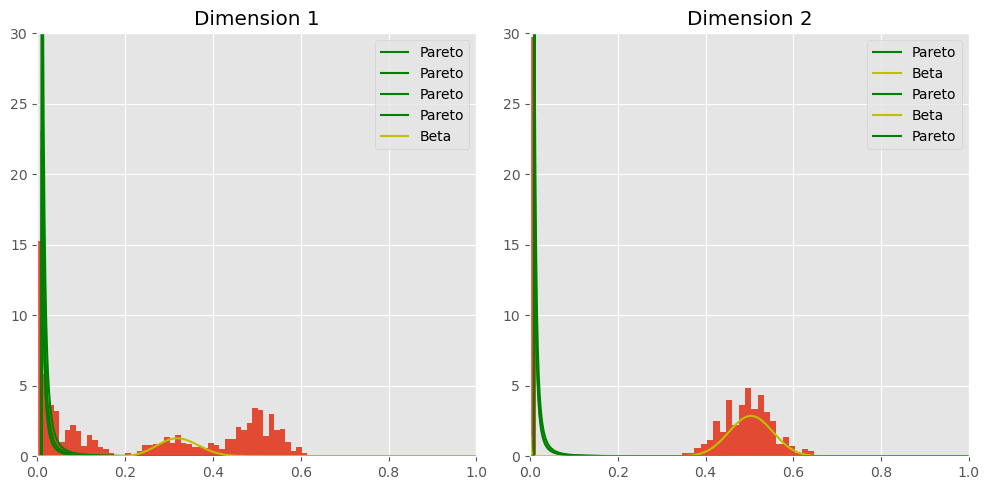

Iteration 1800: Loss = 12119572.0
Iteration 2000: Loss = 12119554.0
phi_beta [[4.3960845e-01 5.1986426e-06]
 [2.6379738e-02 5.0342315e-01]
 [4.7725385e-01 4.9233001e-01]
 [1.0893013e-01 1.1134357e-04]
 [3.1637964e-01 1.8208948e-05]]
delta [[[0.7900471  0.20995294]
  [0.97895104 0.02104894]]

 [[0.68320143 0.31679857]
  [0.4683319  0.53166807]]

 [[0.66321576 0.33678427]
  [0.63883054 0.3611694 ]]

 [[0.55003506 0.44996497]
  [0.02820192 0.9717981 ]]

 [[0.47362298 0.5263771 ]
  [0.99439245 0.00560761]]]


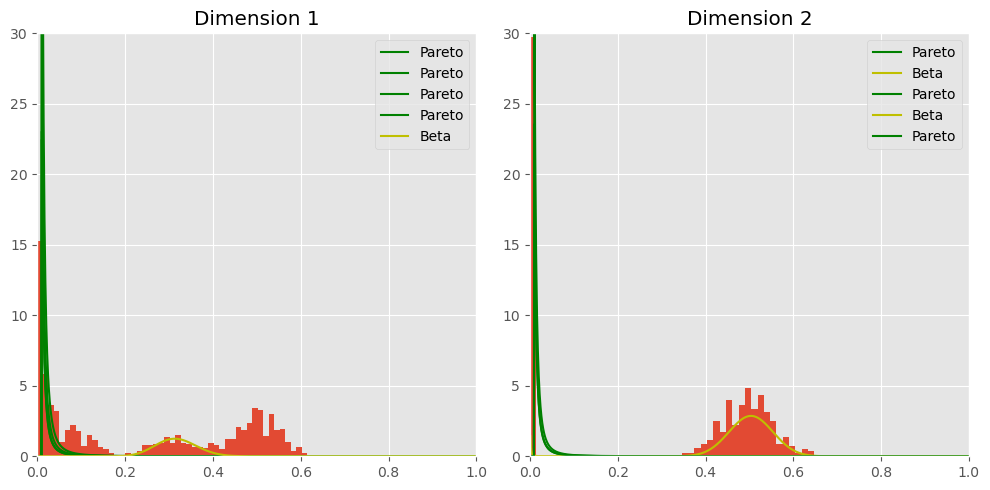

Iteration 2200: Loss = 12119500.0
Iteration 2400: Loss = 12119524.0
phi_beta [[4.3144113e-01 4.4558701e-06]
 [2.6378457e-02 5.0342351e-01]
 [4.7711277e-01 4.9233377e-01]
 [1.0885335e-01 1.1090799e-04]
 [3.1367853e-01 1.6545735e-05]]
delta [[[0.7796466  0.22035341]
  [0.98351717 0.01648281]]

 [[0.683164   0.316836  ]
  [0.46832252 0.5316774 ]]

 [[0.6628466  0.33715332]
  [0.6388128  0.36118725]]

 [[0.55119175 0.44880822]
  [0.02237091 0.97762907]]

 [[0.49791774 0.5020822 ]
  [0.99559975 0.00440027]]]


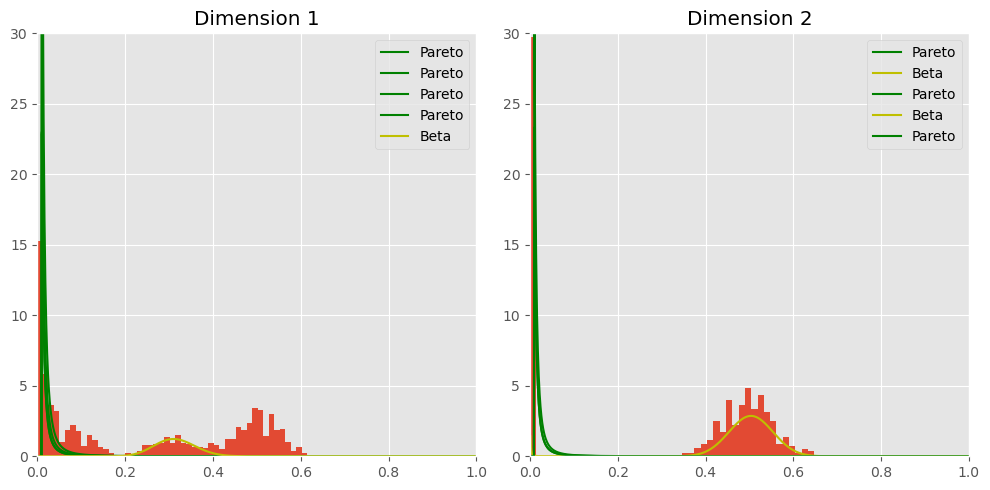

Iteration 2600: Loss = 12119504.0
Iteration 2800: Loss = 12119450.0
phi_beta [[4.2598683e-01 3.8990943e-06]
 [2.6392821e-02 5.0342637e-01]
 [4.7702545e-01 4.9233609e-01]
 [1.0879805e-01 1.1058614e-04]
 [3.1163517e-01 1.5197094e-05]]
delta [[[0.77125555 0.22874445]
  [0.9869445  0.01305549]]

 [[0.6835214  0.31647858]
  [0.46842158 0.5315785 ]]

 [[0.6623093  0.3376907 ]
  [0.638631   0.361369  ]]

 [[0.55183053 0.44816944]
  [0.01827656 0.9817234 ]]

 [[0.5180206  0.4819794 ]
  [0.9964664  0.0035336 ]]]


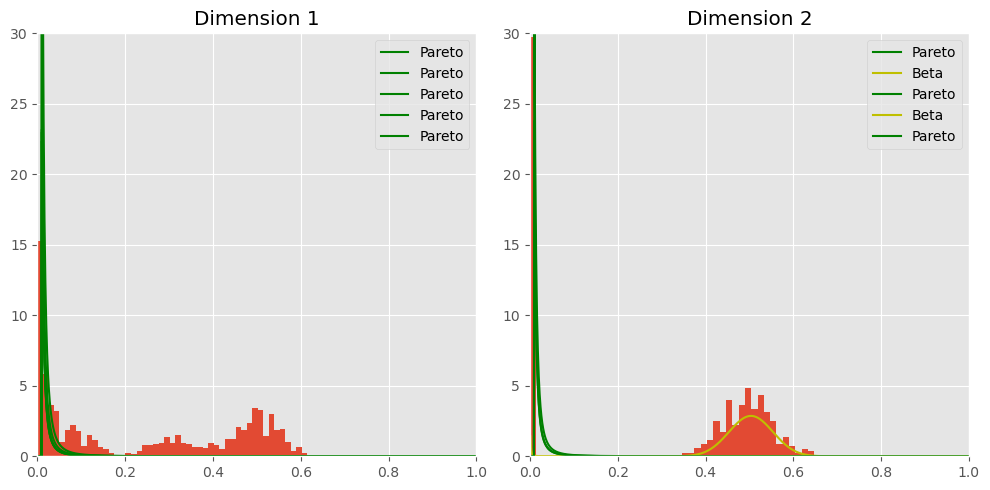

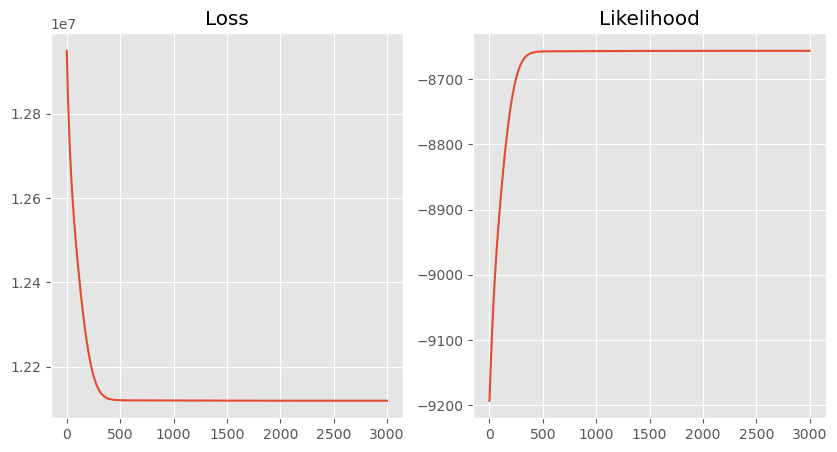

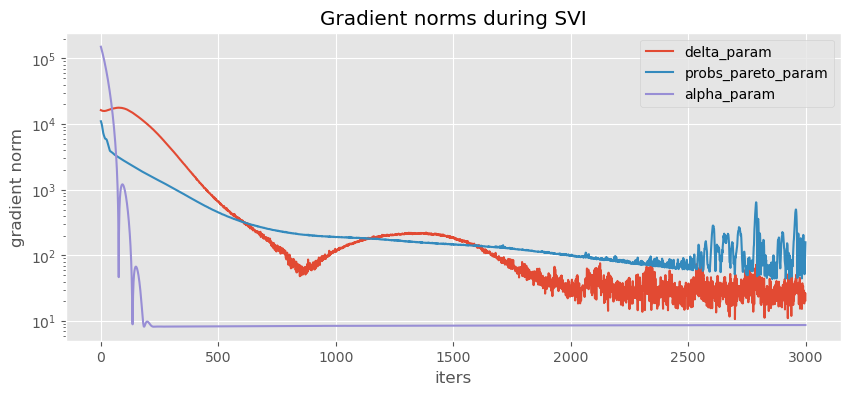

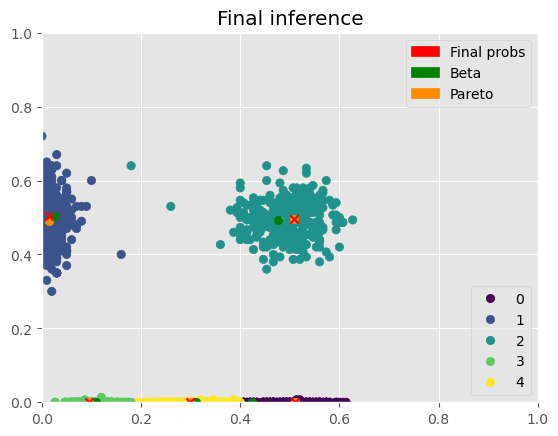

In [97]:
mb = mobster_MV(NV, DP, K = 5, seed = 123)
mb.fit(num_iter = 3000, lr = 0.005)

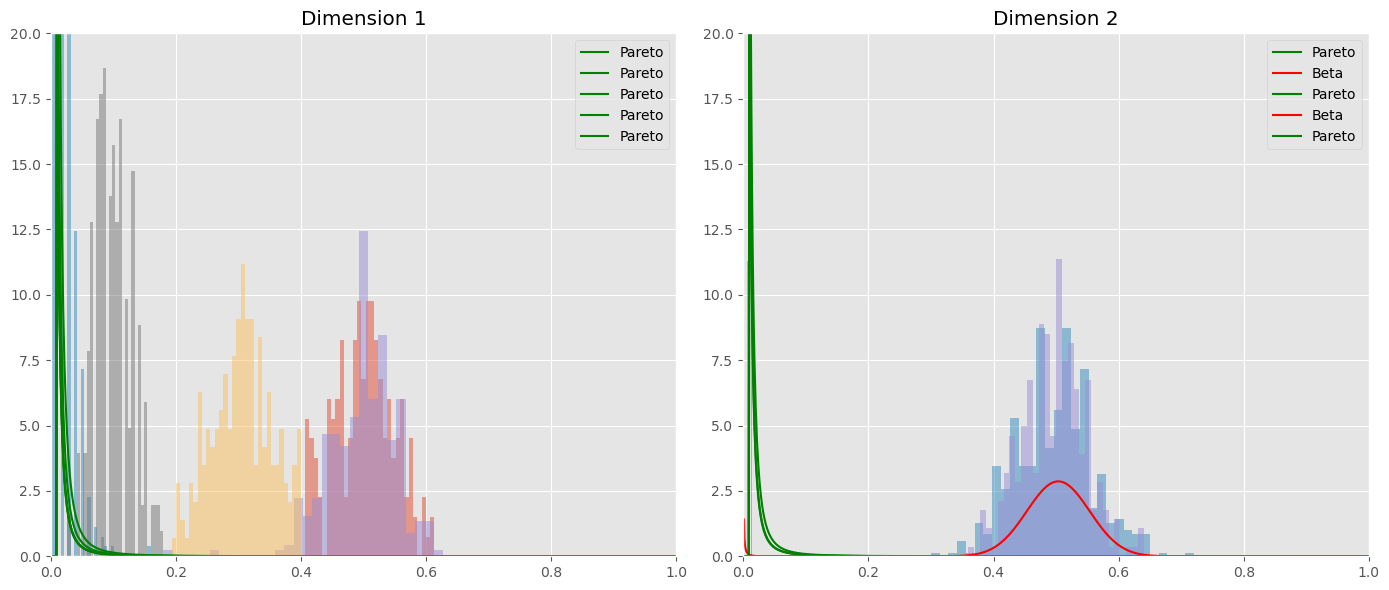

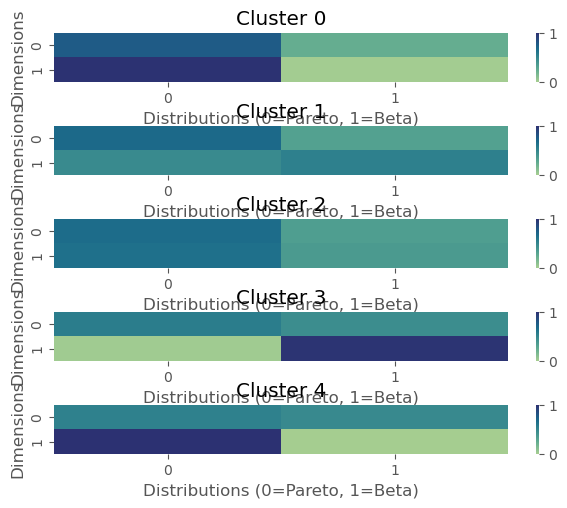

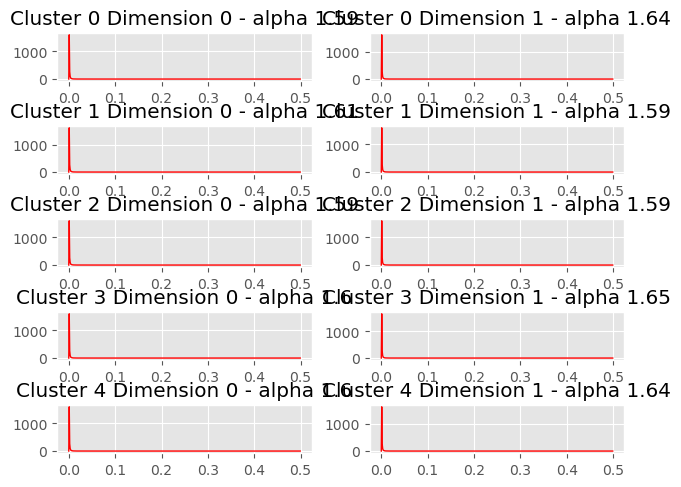

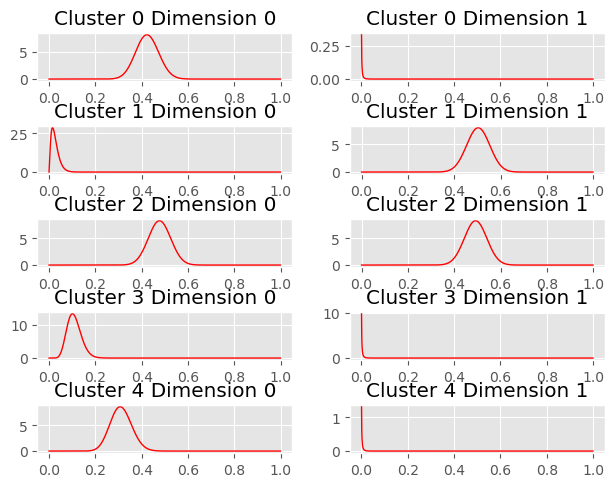

In [98]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [99]:
mb.params

{'probs_pareto': tensor([[5.0967e-01, 8.7512e-05],
         [1.4047e-02, 4.9003e-01],
         [5.0918e-01, 4.9649e-01],
         [9.4648e-02, 1.1165e-05],
         [2.9840e-01, 8.0399e-05]]),
 'weights': tensor([0.1463, 0.3564, 0.2150, 0.1433, 0.1390]),
 'delta': tensor([[[0.7677, 0.2323],
          [0.9884, 0.0116]],
 
         [[0.6829, 0.3171],
          [0.4683, 0.5317]],
 
         [[0.6624, 0.3376],
          [0.6385, 0.3615]],
 
         [[0.5521, 0.4479],
          [0.0167, 0.9833]],
 
         [[0.5267, 0.4733],
          [0.9968, 0.0032]]]),
 'alpha_pareto': tensor([[1.5927, 1.6417],
         [1.6128, 1.5929],
         [1.5927, 1.5929],
         [1.6021, 1.6509],
         [1.5958, 1.6417]]),
 'alpha_prior': tensor([[2.4587, 2.5817],
         [2.5084, 2.4592],
         [2.4587, 2.4591],
         [2.4818, 2.6054],
         [2.4661, 2.5817]]),
 'phi_beta': tensor([[4.2389e-01, 3.6716e-06],
         [2.6366e-02, 5.0343e-01],
         [4.7699e-01, 4.9233e-01],
         [1.0880e-0

### With 3 beta components

In [100]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.1, k_beta_x = 250, phi_beta_y = 0.1, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

torch.Size([2800, 2])
torch.Size([2800, 2])


In [101]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

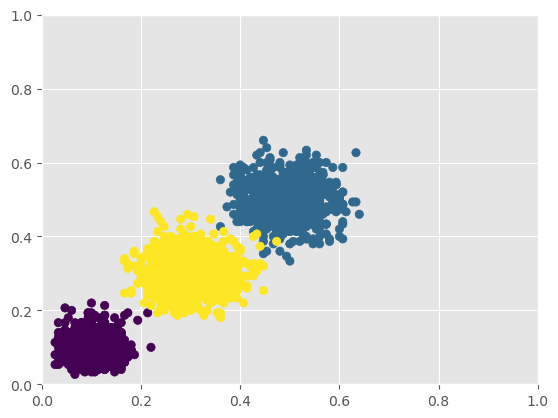

In [102]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

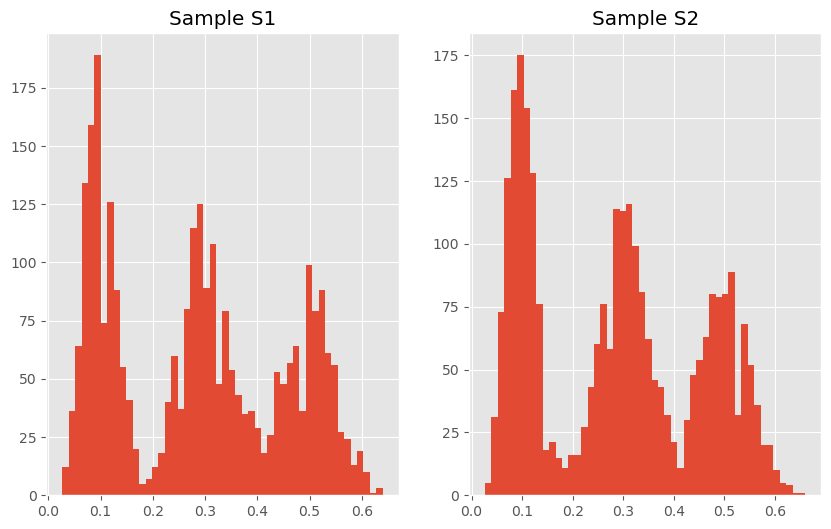

In [103]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

kmeans_centers:  tensor([[0.4994, 0.4985],
        [0.3003, 0.3027],
        [0.0985, 0.0993]])
Iteration 0: Loss = 60782972.0
weights_param tensor([0.5653, 0.1824, 0.2524], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0040, 2.0040],
        [2.0040, 2.0040],
        [2.0040, 2.0040]], grad_fn=<AddBackward0>)
alpha_param tensor([[1.9960, 1.9960],
        [1.9960, 1.9960],
        [1.9960, 1.9960]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[0.4994, 0.4985],
        [0.3001, 0.3026],
        [0.0984, 0.0995]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 99.8003, 100.1997],
        [100.2002, 100.2002],
        [100.2002,  99.8002]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[0.4994, 0.4985],
        [0.3001, 0.3025],
        [0.0987, 0.0992]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.7837, 0.2163],
         [0.6545, 0.3455]],

        [[0.3095, 0.6905],
         [0.3521, 0.6479]],

        [[0.5071, 0.4929],
         [0.9846, 0.0154]]], grad_fn=<DivBackwa

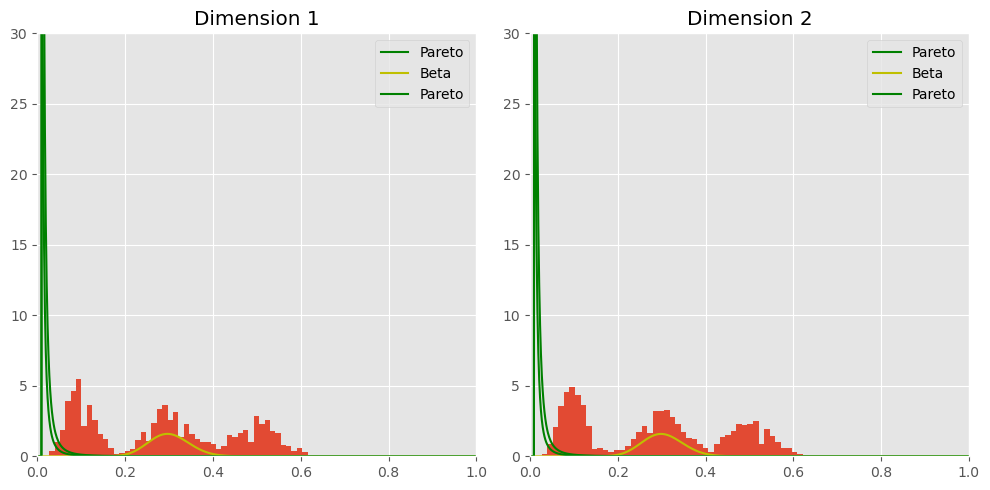

Iteration 200: Loss = 59974404.0
Iteration 400: Loss = 59571024.0
phi_beta [[0.49386135 0.4945782 ]
 [0.30199018 0.3039146 ]
 [0.09655257 0.13803425]]
delta [[[0.644085   0.355915  ]
  [0.52581096 0.474189  ]]

 [[0.42379448 0.5762055 ]
  [0.48413602 0.51586396]]

 [[0.48954573 0.51045424]
  [0.96259993 0.03740004]]]


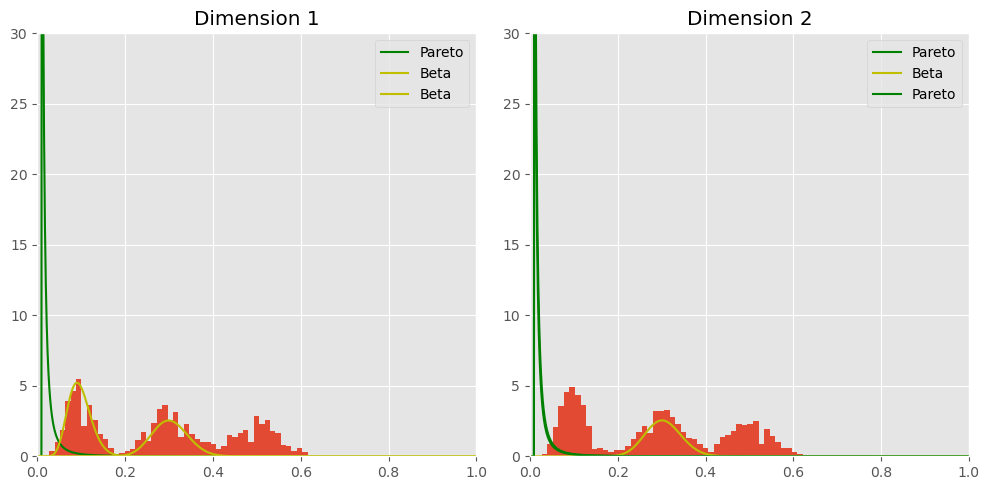

Iteration 600: Loss = 59379392.0
Iteration 800: Loss = 59294916.0
phi_beta [[0.49086472 0.49492738]
 [0.30301026 0.3048447 ]
 [0.0969379  0.14327785]]
delta [[[0.5446664  0.45533362]
  [0.5000551  0.49994496]]

 [[0.43860564 0.56139433]
  [0.52206415 0.47793582]]

 [[0.4364453  0.5635547 ]
  [0.9276022  0.07239786]]]


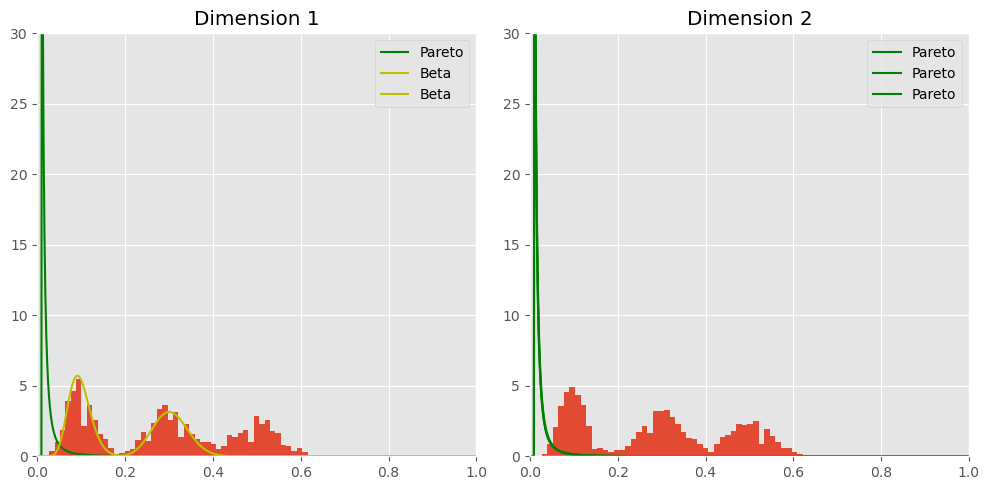

Iteration 1000: Loss = 59259448.0
Iteration 1200: Loss = 59243736.0
phi_beta [[0.4919245  0.49556917]
 [0.30332944 0.30520627]
 [0.09697918 0.12945555]]
delta [[[0.5003788  0.49962118]
  [0.49994755 0.50005245]]

 [[0.43874434 0.5612557 ]
  [0.5338395  0.4661605 ]]

 [[0.42780814 0.57219183]
  [0.8720648  0.12793517]]]


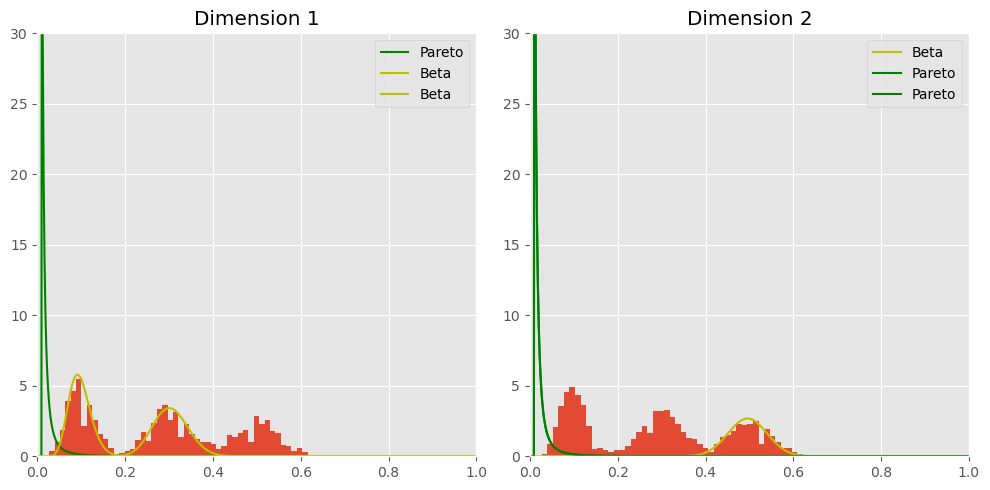

Iteration 1400: Loss = 59233512.0
Iteration 1600: Loss = 59220560.0
phi_beta [[0.49252668 0.49576813]
 [0.30336997 0.30528522]
 [0.09695118 0.10870565]]
delta [[[0.48381522 0.51618475]
  [0.5008486  0.49915144]]

 [[0.43953425 0.5604657 ]
  [0.53983825 0.46016175]]

 [[0.4279564  0.57204354]
  [0.76137215 0.23862787]]]


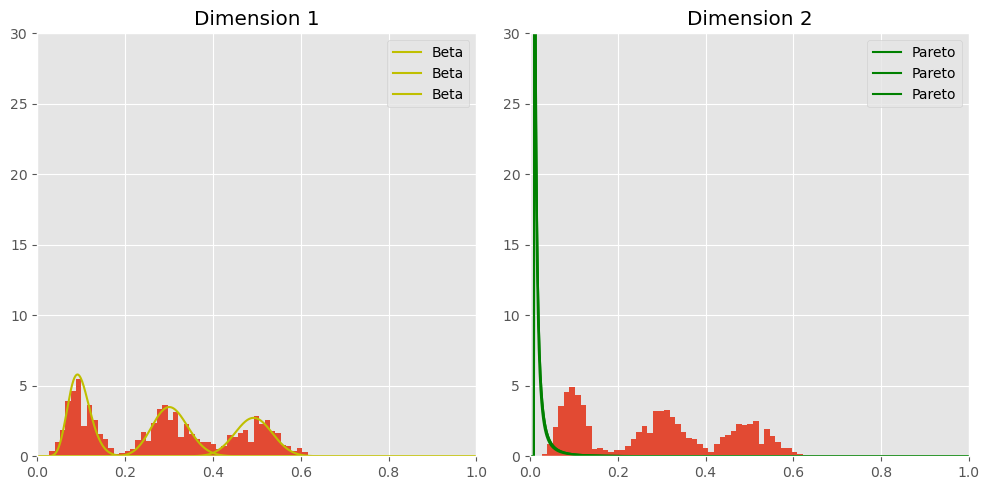

Iteration 1800: Loss = 59213020.0
Iteration 2000: Loss = 59209416.0
phi_beta [[0.49268684 0.49580503]
 [0.30339217 0.3053444 ]
 [0.09695423 0.10245606]]
delta [[[0.4793582  0.5206418 ]
  [0.5009799  0.49902007]]

 [[0.44006062 0.5599394 ]
  [0.5423919  0.45760813]]

 [[0.4279765  0.5720235 ]
  [0.63434494 0.36565506]]]


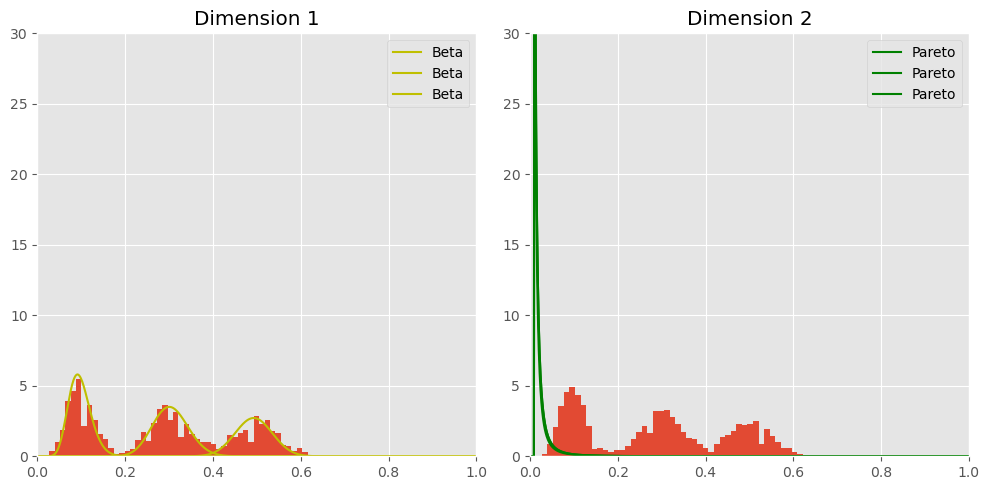

Iteration 2200: Loss = 59207768.0
Iteration 2400: Loss = 59207400.0
phi_beta [[0.49271253 0.49580947]
 [0.303404   0.30537274]
 [0.09695852 0.10159118]]
delta [[[0.4785025  0.52149755]
  [0.50102705 0.49897295]]

 [[0.44062862 0.55937135]
  [0.5431696  0.4568304 ]]

 [[0.42780003 0.57219994]
  [0.56421405 0.43578592]]]


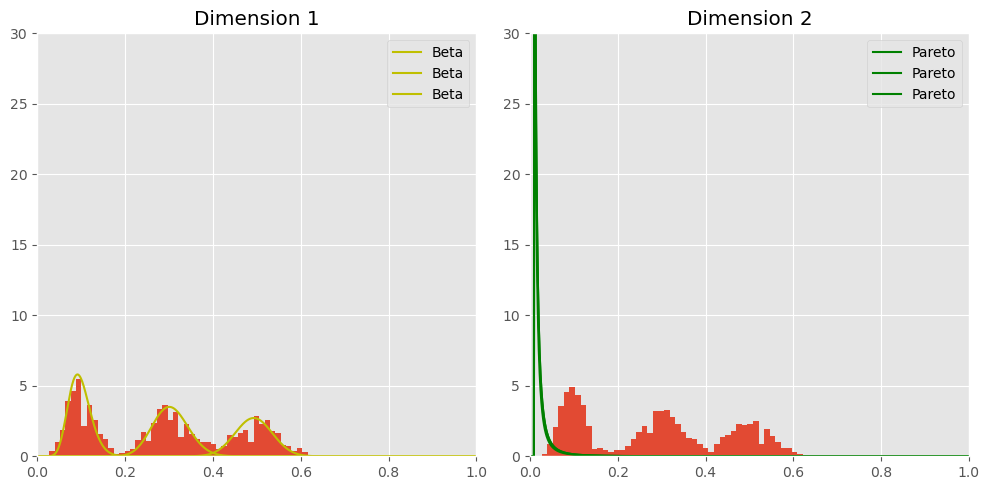

Iteration 2600: Loss = 59207028.0
Iteration 2800: Loss = 59207080.0
phi_beta [[0.49271482 0.4958096 ]
 [0.30340806 0.305378  ]
 [0.09696851 0.10129213]]
delta [[[0.47844687 0.5215531 ]
  [0.50114596 0.498854  ]]

 [[0.440841   0.559159  ]
  [0.5433339  0.4566661 ]]

 [[0.42766    0.57234   ]
  [0.531829   0.46817103]]]


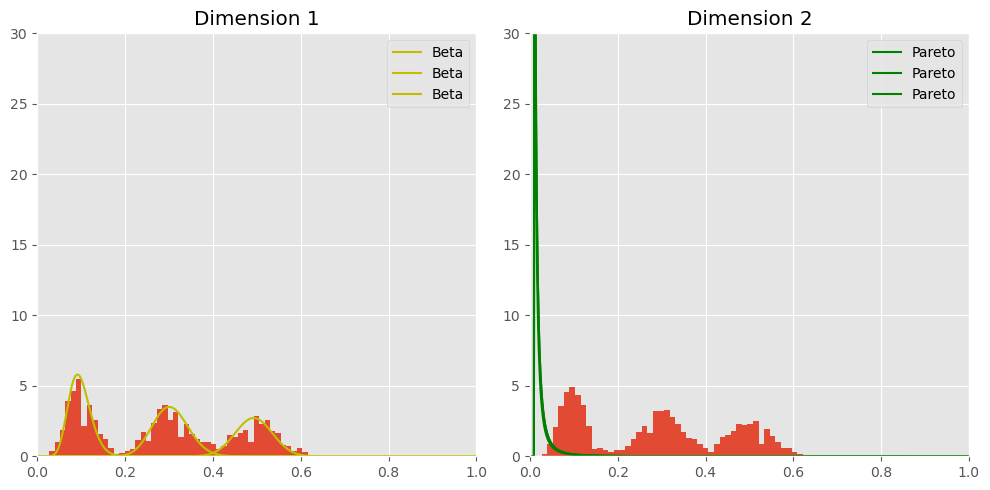

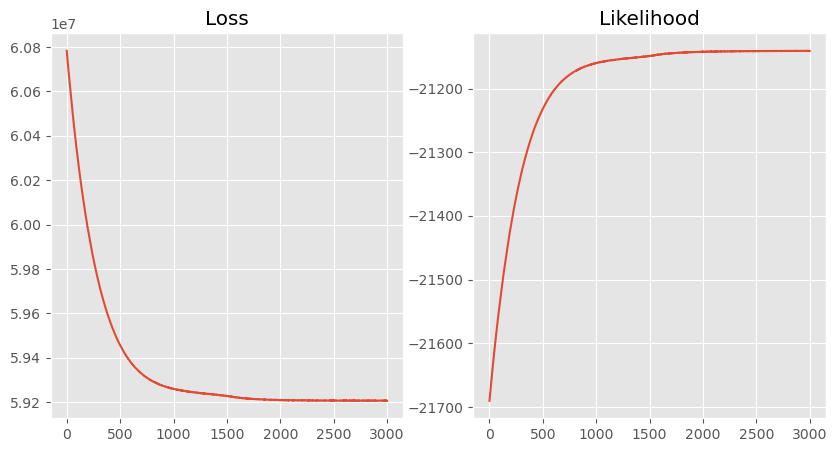

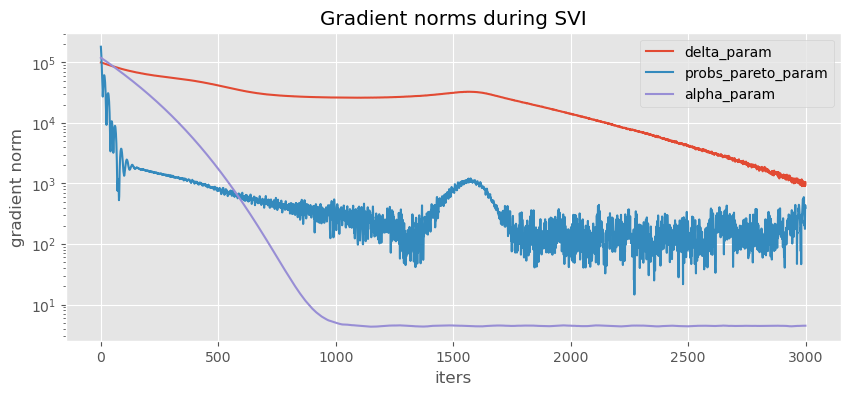

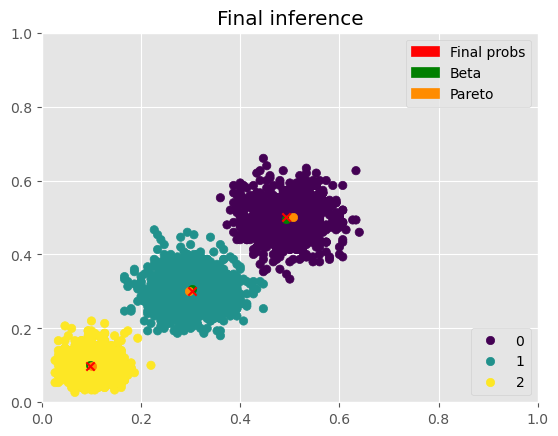

In [104]:
mb = mobster_MV(NV, DP, K = 3, seed = 821)
mb.fit(num_iter = 3000, lr = 0.001)

In [105]:
mb.params

{'probs_pareto': tensor([[0.5061, 0.5009],
         [0.2964, 0.3003],
         [0.1007, 0.0977]]),
 'weights': tensor([0.2867, 0.3567, 0.3566]),
 'delta': tensor([[[0.4783, 0.5217],
          [0.5011, 0.4989]],
 
         [[0.4409, 0.5591],
          [0.5434, 0.4566]],
 
         [[0.4275, 0.5725],
          [0.5240, 0.4760]]]),
 'alpha_pareto': tensor([[1.6127, 1.6127],
         [1.6129, 1.6129],
         [1.6134, 1.6134]]),
 'alpha_prior': tensor([[2.5082, 2.5082],
         [2.5088, 2.5088],
         [2.5100, 2.5101]]),
 'phi_beta': tensor([[0.4927, 0.4958],
         [0.3034, 0.3054],
         [0.0970, 0.1012]]),
 'k_beta': tensor([[141.3049, 127.7334],
         [128.0960, 126.0443],
         [139.7030, 126.6270]]),
 'responsib': tensor([[0.0000e+00, 2.8026e-44, 0.0000e+00,  ..., 1.2672e-16, 2.6911e-11,
          1.7462e-12],
         [1.6017e-15, 1.0930e-13, 6.4479e-21,  ..., 1.0000e+00, 1.0000e+00,
          1.0000e+00],
         [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.6733e-1

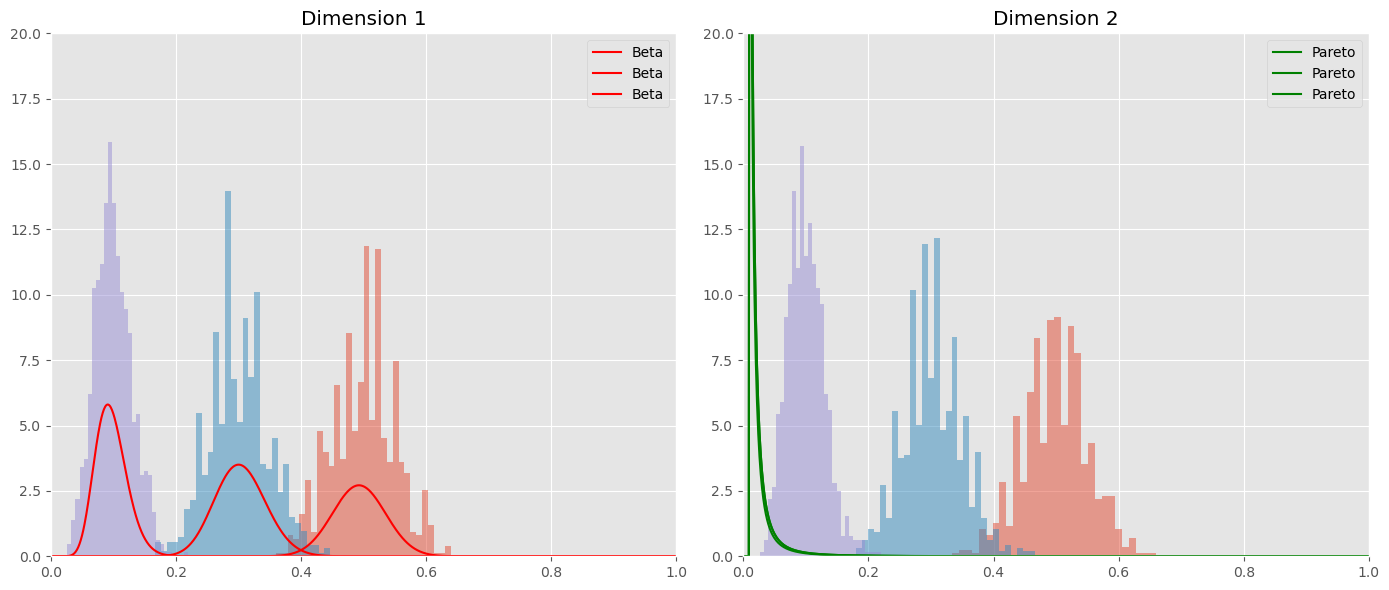

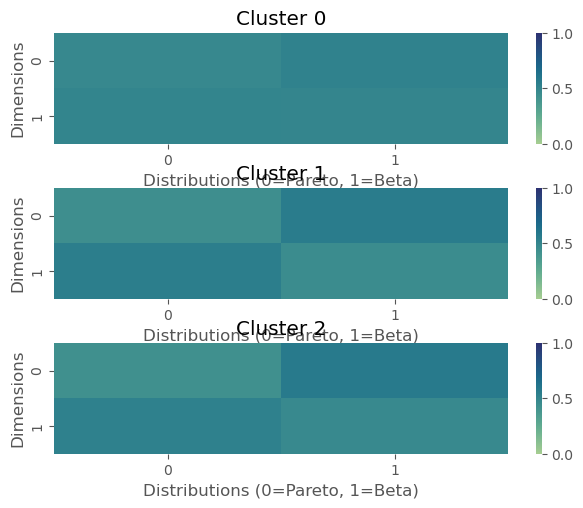

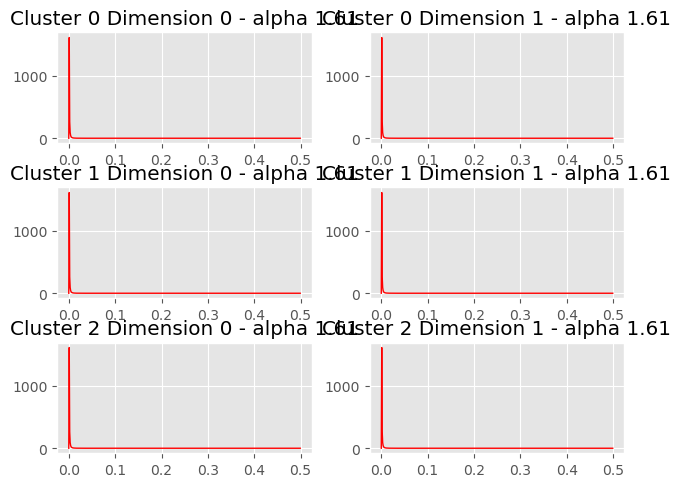

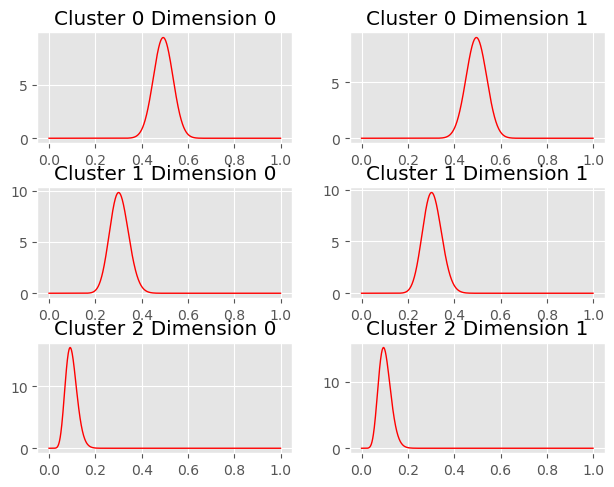

In [106]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

### With 3 beta components (1 private)

In [107]:
N1 = 1000
N2 = 800
N3 = 1000

NV1, DP1 = beta_binomial_component(phi_beta_x = 0.4, k_beta_x = 250, phi_beta_y = 0.0001, k_beta_y= 250, n=150, N=N1, seed=seed)
NV2, DP2 = beta_binomial_component(phi_beta_x = 0.5, k_beta_x = 250, phi_beta_y = 0.5, k_beta_y= 250, n=150, N=N2, seed=seed)
NV3, DP3 = beta_binomial_component(phi_beta_x = 0.3, k_beta_x = 250, phi_beta_y = 0.3, k_beta_y= 250, n=150, N=N3, seed=seed)

NV = torch.concat((NV1,NV2))
NV = torch.concat((NV,NV3))
print(NV.shape)
# print(NV)
DP = torch.concat((DP1,DP2))
DP = torch.concat((DP,DP3))
print(DP.shape)
# print(DP)

torch.Size([2800, 2])
torch.Size([2800, 2])


In [108]:
labels_1 = np.zeros(N1)
labels_2 = np.ones(N2)
labels_3 = np.ones(N3) * 3

labels = np.concatenate((labels_1, labels_2))
labels = np.concatenate((labels, labels_3))

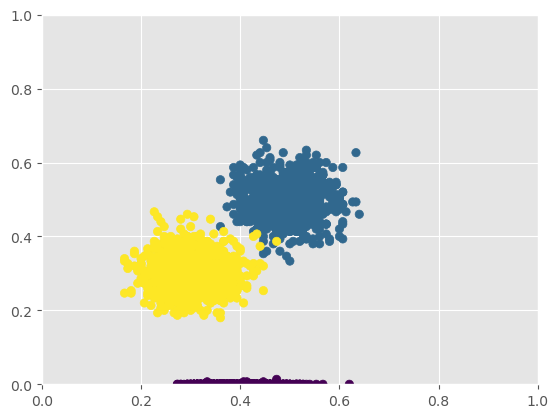

In [109]:
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = labels)

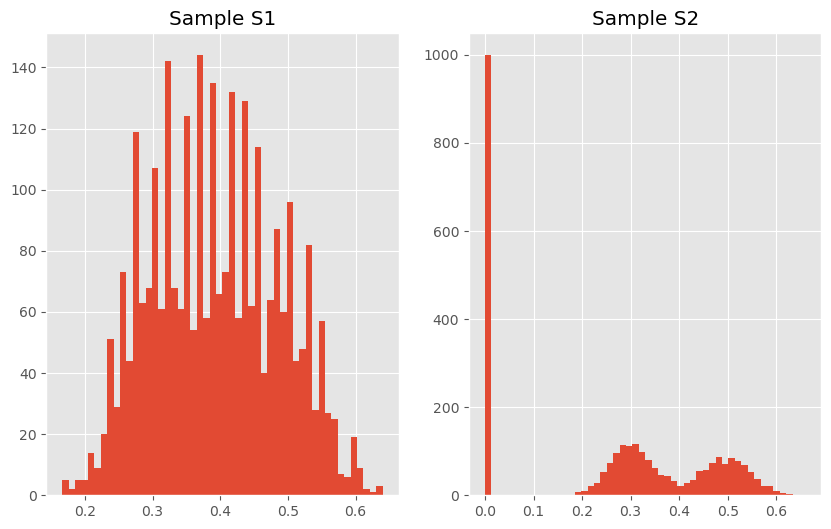

In [110]:
# x = np.linspace(0.001, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# Sample S1
axes[0].hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
axes[0].set_title("Sample S1")

axes[1].hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
axes[1].set_title("Sample S2")
plt.show()

kmeans_centers:  tensor([[4.0035e-01, 3.9876e-05],
        [4.9931e-01, 4.9832e-01],
        [3.0027e-01, 3.0281e-01]])
Iteration 0: Loss = 52949956.0
weights_param tensor([0.3689, 0.3738, 0.2573], grad_fn=<DivBackward0>)
alpha_prior_param tensor([[2.0040, 2.0040],
        [2.0040, 2.0040],
        [2.0040, 2.0040]], grad_fn=<AddBackward0>)
alpha_param tensor([[1.9960, 1.9960],
        [1.9960, 1.9960],
        [1.9960, 1.9960]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[4.0053e-01, 3.9955e-05],
        [4.9929e-01, 4.9830e-01],
        [3.0052e-01, 3.0305e-01]], grad_fn=<AddBackward0>)
k_beta_param tensor([[ 99.8002, 100.2003],
        [100.2002, 100.2002],
        [100.2001, 100.2002]], grad_fn=<AddBackward0>)
probs_pareto_param tensor([[4.0018e-01, 3.9955e-05],
        [4.9933e-01, 4.9835e-01],
        [3.0003e-01, 3.0256e-01]], grad_fn=<AddBackward0>)
delta_param tensor([[[0.8904, 0.1096],
         [0.3567, 0.6433]],

        [[0.2749, 0.7251],
         [0.4878, 0.5122]],

  

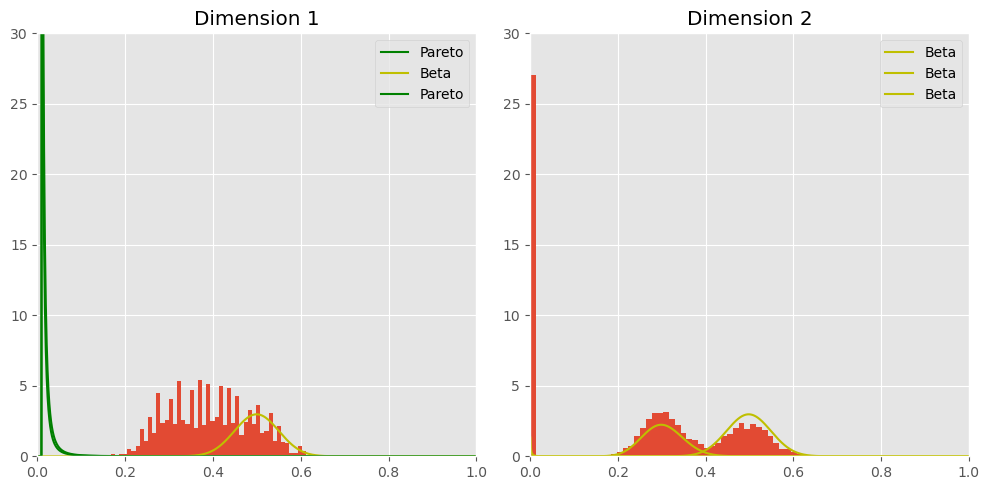

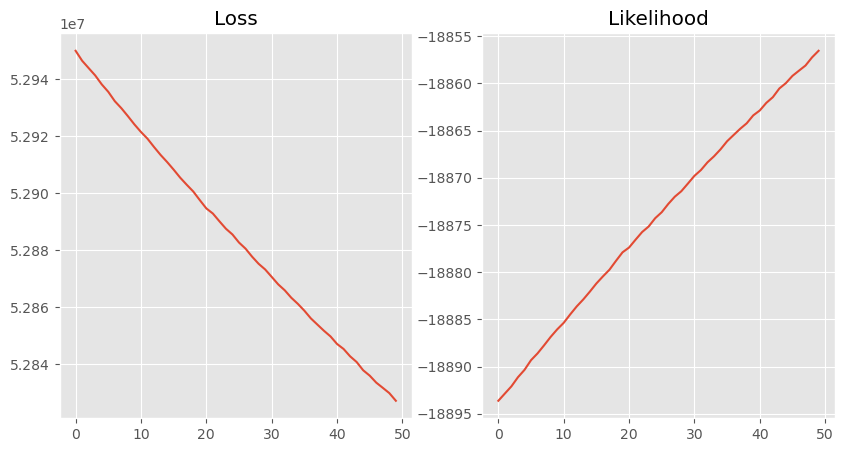

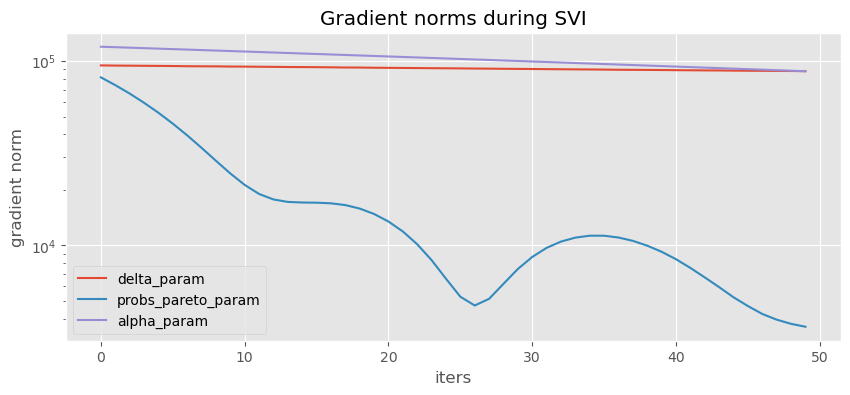

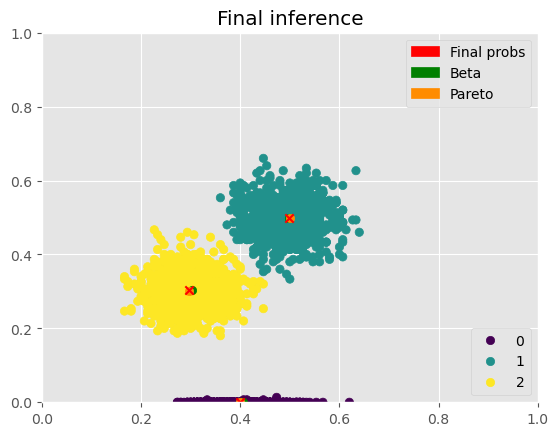

In [111]:
mb = mobster_MV(NV, DP, K = 3, seed = 48)
mb.fit(num_iter = 3000, lr = 0.001)

In [112]:
mb.params

{'probs_pareto': tensor([[3.9898e-01, 4.1727e-05],
         [4.9983e-01, 4.9887e-01],
         [2.9748e-01, 3.0098e-01]]),
 'weights': tensor([0.3610, 0.3635, 0.2754]),
 'delta': tensor([[[0.8805, 0.1195],
          [0.3588, 0.6412]],
 
         [[0.2945, 0.7055],
          [0.5107, 0.4893]],
 
         [[0.5445, 0.4555],
          [0.1386, 0.8614]]]),
 'alpha_pareto': tensor([[1.9044, 1.9044],
         [1.9044, 1.9044],
         [1.9044, 1.9044]]),
 'alpha_prior': tensor([[2.1011, 2.1011],
         [2.1011, 2.1011],
         [2.1011, 2.1011]]),
 'phi_beta': tensor([[4.0473e-01, 4.1832e-05],
         [4.9879e-01, 4.9775e-01],
         [3.0372e-01, 3.0362e-01]]),
 'k_beta': tensor([[ 95.1825, 102.5682],
         [105.1296, 104.9853],
         [104.8212, 105.1577]]),
 'responsib': tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
          0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.1771e-16, 3.7560e-11,
          9.2175e-13],
         [9.0

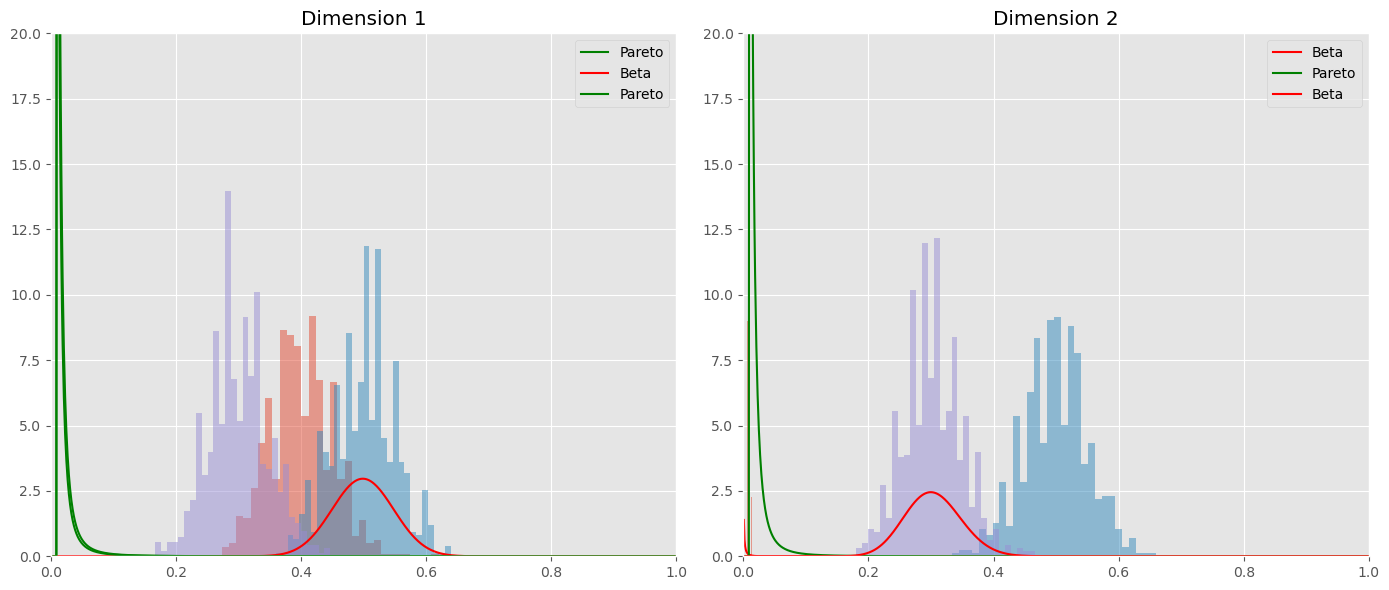

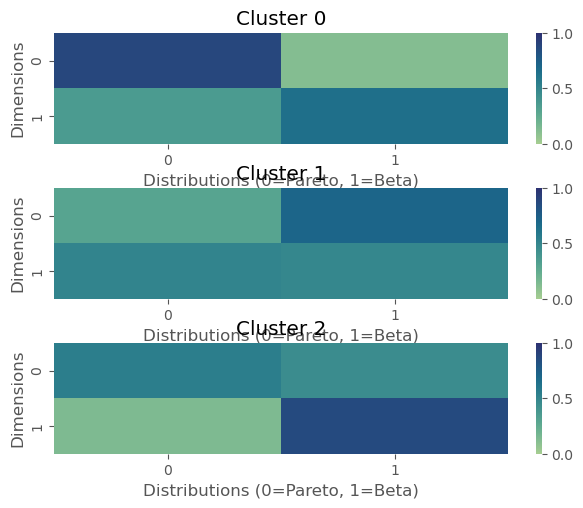

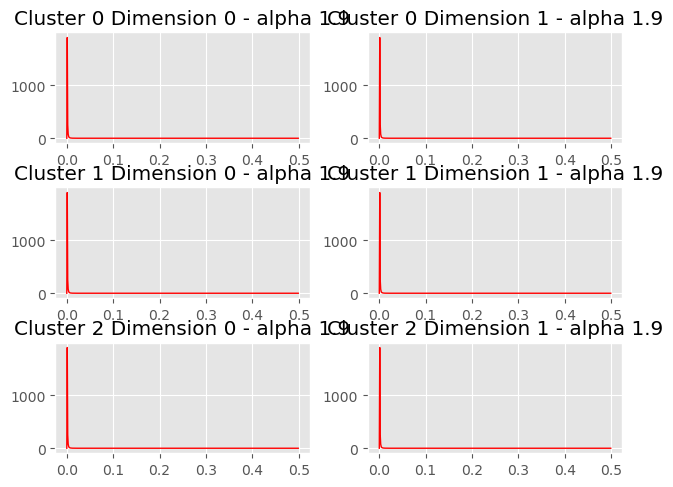

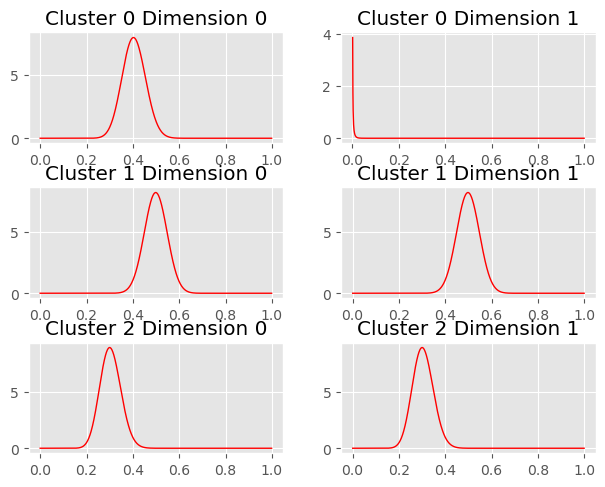

In [113]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)